## 患者投诉分类

### 1、ZeroShotPromptTemplate: 20%样本直接进行测试    
### 2、FewShotPromptTemplate：未全量测试，效果略优于方法1    
### 3、读入表文件后进行文本分类：80%学习，20%测试  
### 4、本地知识库embedding：80%学习，20%测试    
### 5、进行Fine_tuning：80%学习，20%测试

#### 原始样本685条、22个类别；清洗、规整、消除尾部类别后，实际样本635条、11个类别

#### 1、zeroshot (GPT3.5): Accuracy 0.60，加权Precision 0.69，加权Recall 0.60，加权F1 0.61
#### 3、table agent (GPT3): Accuracy 0.49，加权Precision 0.57，加权Recall 0.49，加权F1 0.49
#### 4、embedding (GPT3.5): Accuracy 0.62，加权Precision 0.74，加权Recall 0.62，加权F1 0.66
#### 5、Fine_tuning (GPT3): Accuracy 0.76，加权Precision 0.84，加权Recall 0.76，加权F1 0.75

### 1、数据预处理：重新人工打标、剔除尾部类别

In [1]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.llms import OpenAI
import pandas as pd
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAIChat
import os

os.environ["OPENAI_API_KEY"] = '***'

In [2]:
df_origin = pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/CaseSample_Adj.xlsx')
df_origin

,Case Description (HAGo),Category,Adj_Category
0,Cant login to ha go account nor forgot usernam...,Login/ Logout,Login
1,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,Minor
2,Cant login to ha go account nor forgot usernam...,Registration/ Activation,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Registration/ Activation,Login
4,有冇處理緊?,Login/ Logout,Others
...,...,...,...
680,你好，我媽媽於2022年8月在荃灣戴麟趾診所抽血，為什麼在HA Go 找不到這份化驗報告，請...,My Record,My Record
681,你好！請問我在HA做了驗血及驗尿等後，要幾多天才有報告？而那些報告又要多少天才上傳到我的HA...,My Record,My Record
682,施小姐查詢在一般情況下，需要在報告結果發出後多久，才能在本局流動應用程式「HA Go」查閱及...,My Record,My Record
683,請問HA Go 「我的健康」內的「我的紀錄」內「我的報告」的驗血報告睇醫生後幾時會放上HA ...,My Record,My Record


In [175]:
df_origin.to_csv('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/origin_24class.csv', encoding='utf_8_sig')

In [4]:
## 去重后，一共有685条实例、22个类别
df_origin.describe()

,Case Description (HAGo),Category,Adj_Category
count,685,685,685
unique,677,22,24
top,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login/ Logout,Login
freq,3,146,139


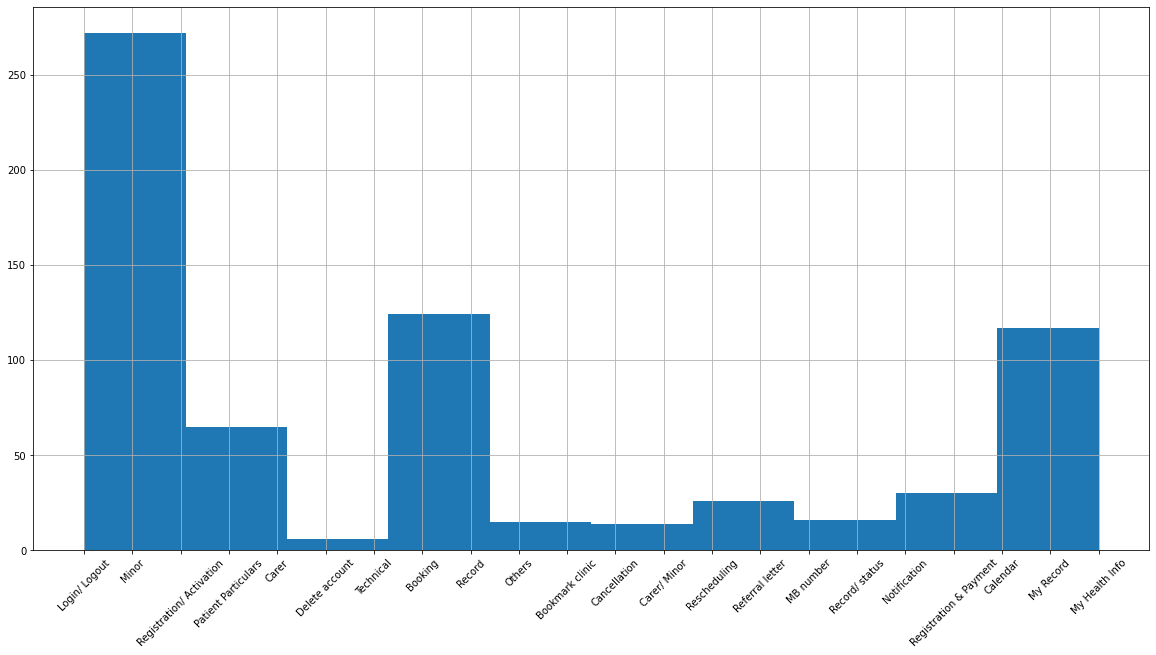

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
df_origin['Category'].hist()
plt.show()

In [12]:
## 重新人工打标规整，去除尾部类别

df_sample = pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/SampleDataset_11class.xlsx')
df_sample

,Case Description (HAGo),LABEL
0,Cant login to ha go account nor forgot usernam...,Login
1,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor
2,Cant login to ha go account nor forgot usernam...,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login
4,有冇處理緊?,Others
...,...,...
627,你好，我媽媽於2022年8月在荃灣戴麟趾診所抽血，為什麼在HA Go 找不到這份化驗報告，請...,Record
628,你好！請問我在HA做了驗血及驗尿等後，要幾多天才有報告？而那些報告又要多少天才上傳到我的HA...,Record
629,施小姐查詢在一般情況下，需要在報告結果發出後多久，才能在本局流動應用程式「HA Go」查閱及...,Record
630,請問HA Go 「我的健康」內的「我的紀錄」內「我的報告」的驗血報告睇醫生後幾時會放上HA ...,Record


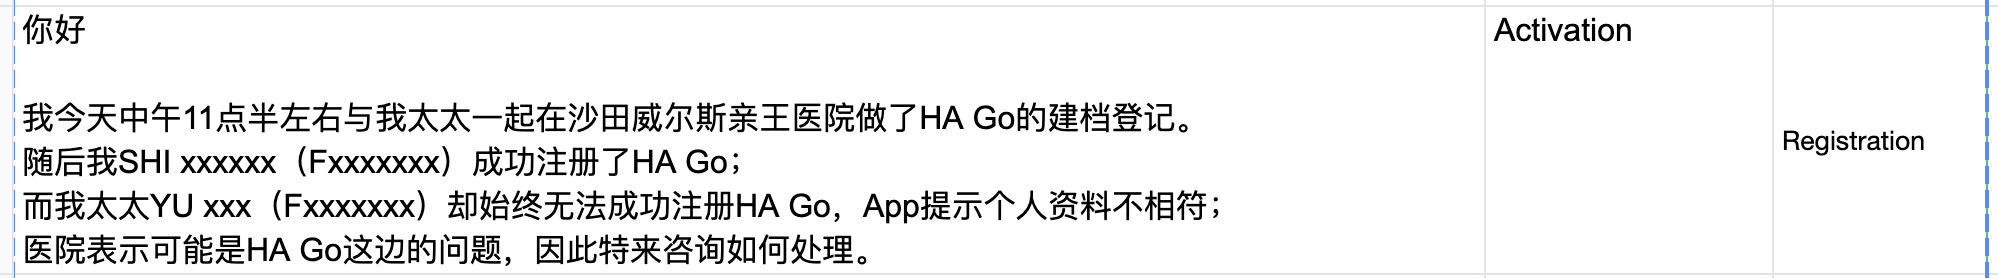
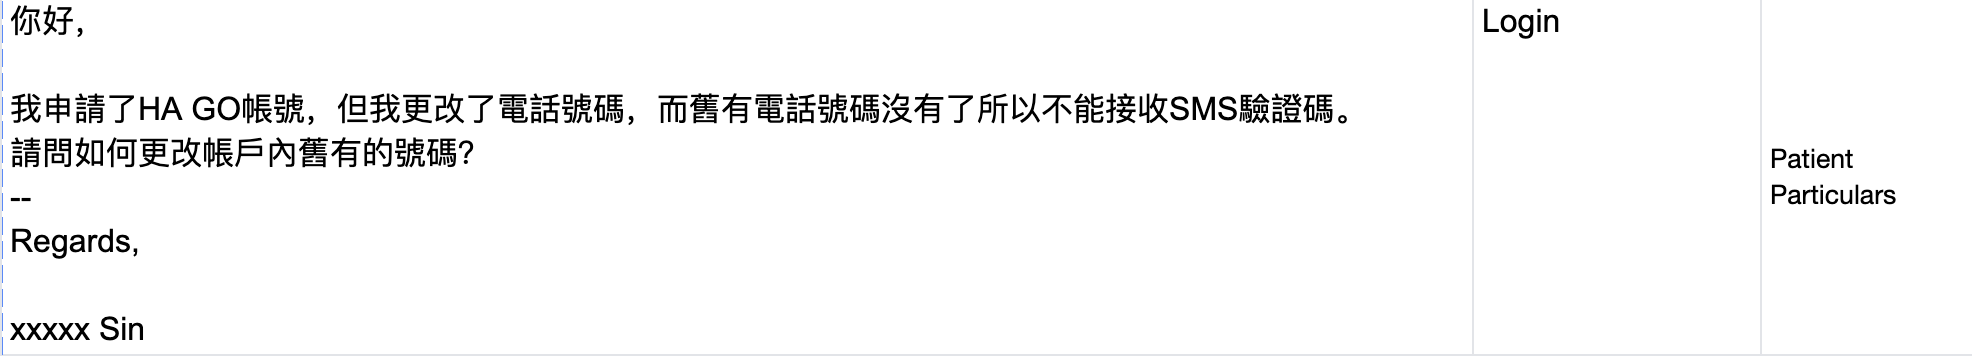

In [13]:
## 去重后，一共有632条实例、11个类别
df_sample.describe()

,Case Description (HAGo),LABEL
count,632,632
unique,632,11
top,Cant login to ha go account nor forgot usernam...,Record
freq,1,173


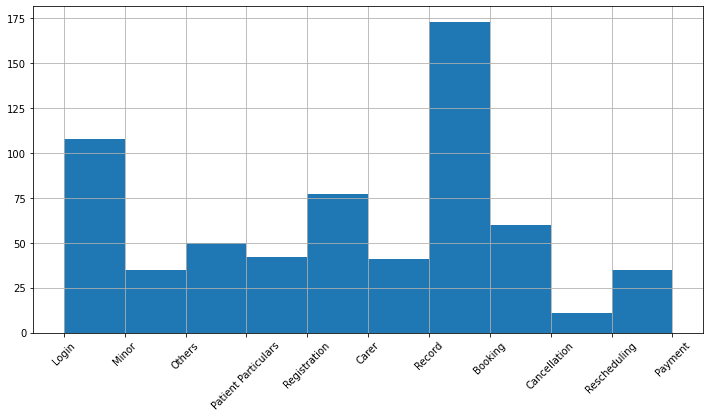

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)
df_sample['LABEL'].hist()
plt.show()

In [110]:
## 消除换行符
df_sample['Case Description (HAGo)']=df_sample['Case Description (HAGo)'].apply(lambda x: x.replace("\n","."))
df_sample

,Case Description (HAGo),LABEL
0,Cant login to ha go account nor forgot usernam...,Login
1,"Dear Sir, 你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以...",Minor
2,Cant login to ha go account nor forgot usernam...,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login
4,有冇處理緊?,Others
...,...,...
627,你好，我媽媽於2022年8月在荃灣戴麟趾診所抽血，為什麼在HA Go 找不到這份化驗報告，請...,Record
628,你好！請問我在HA做了驗血及驗尿等後，要幾多天才有報告？而那些報告又要多少天才上傳到我的HA...,Record
629,施小姐查詢在一般情況下，需要在報告結果發出後多久，才能在本局流動應用程式「HA Go」查閱及...,Record
630,請問HA Go 「我的健康」內的「我的紀錄」內「我的報告」的驗血報告睇醫生後幾時會放上HA ...,Record


### 2、样本数据集切分

In [111]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(df_sample, test_size=0.2, random_state=26)

In [103]:
data_test_sample = data_test.iloc[0:3,0:1]
df_test_sample = pd.DataFrame(data_test_sample)
df_test_sample.columns = ['Case']
df_test_sample

,Case
218,My ID card no has 2 English Prefix but the sys...
605,"1/2 的抽血報告沒有出現在ha go, 請幫我查吓，謝謝"
467,Hi 本人(Lam xxx xxxx/I.d.no.Dxxxxxx(x) 我查看過HA ...


### 3.1 zeroshot 零样本学习

In [108]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAIChat
import os

llm = OpenAIChat(model_name='gpt-3.5-turbo', 
             temperature=0, 
             max_tokens = 1000)

# 告诉他我们生成的内容需要哪些字段，每个字段类型
response_categories = ['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']


print(response_categories)


template = """
你是一位APP问题解决助手，请识别并理解用户描述，从{response_categories}中识别用户的需求?
注意，只从给定的需求范围内返回意图最强烈类别的值即可，不需要任何其他信息
如果你判断用户几种意图概率一样，就输出第一个即可

% USER INPUT:
{user_input}

你的回复:
"""


# 有多个输入变量的示例 prompt
multiple_input_prompt = PromptTemplate(
    input_variables=["response_categories", "user_input"], 
    template= template
)

promptValue = multiple_input_prompt.format(response_categories=response_categories, user_input="忘記名稱及密碼")
# -> "Tell me a funny joke about chickens."


result_list=[]
for i in df_test_sample['Case'].iloc[0:3]:
    #user_input = i
    promptValue = multiple_input_prompt.format(response_categories=response_categories, user_input=i)
    llm_output = llm(promptValue)
    print(i)
    result_list.append(llm_output)

#promptValue = prompt.format(response_categories, user_input)
# llm_output = llm(promptValue)

# print(llm_output)

['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']
My ID card no has 2 English Prefix but the system only allow me to type in one. How could I register?  eg. XA******(*)  But you only allow to type in 1 Letter
1/2 的抽血報告沒有出現在ha go, 請幫我查吓，謝謝
Hi   本人(Lam xxx xxxx/I.d.no.Dxxxxxx(x) 我查看過HA GO record, 20 Nov 2023 是有皮膚科預约左，但資料沒有顯示在system內，Pl.  Cross check and reconfirm again to me by phone no. 6xxxxxxx   Tks


In [113]:
data_test.columns = ['Case','LABEL']
data_test_x = data_test['Case']
data_test_x

218    My ID card no has 2 English Prefix but the sys...
605                        1/2 的抽血報告沒有出現在ha go, 請幫我查吓，謝謝
467    Hi   本人(Lam xxx xxxx/I.d.no.Dxxxxxx(x) 我查看過HA ...
35                 我換了新手機, 有影晌嗎？ 舊手機則能登入？ 是用相同户名及密碼去做登入的
329      這個預約程式雖要更改！ 系統應該實時顯示各單位的未約預額以供選擇，而非要求病人逐個單位去查訊！
                             ...                        
110    你好， 我想添加沒有智能電話的長者作為我的被照顧者， 沒有q r code可以 scan， ...
273    我剛收到有關HA Go手提電話的實名登記訊息。但，我這個電話號碼是丈夫在電訊公司的家庭pla...
413    王女士指她不能在HA GO應用程式內查閱CPH覆診期，但她可以查閱TMH專科及普通科門診的覆...
278                                             你好，我登入不到
470    Dear staff,  My account's appointments records...
Name: Case, Length: 127, dtype: object

In [115]:
result_list=[]
for i in data_test['Case']:
    #user_input = i
    promptValue = multiple_input_prompt.format(response_categories=response_categories, user_input=i)
    llm_output = llm(promptValue)
    result_list.append(llm_output)

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIConnectionError: Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')).
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 97253e444c77e7d480059f6aad0b15a4 in your message.).
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f02ca6d147626adfae008fbba37200bb in your

In [124]:
result_list

['Registration',
 'Record',
 'Rescheduling',
 '意图类别：Login',
 'Booking',
 'Record',
 "抱歉，我需要更多信息才能识别您的需求。请告诉我您遇到的具体问题或需要解决的任务。您可以从以下需求范围中选择一个或多个：['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']。",
 'Record',
 '需求类别：Record',
 'Rescheduling',
 'Others',
 'Booking',
 'Record',
 'Patient Particulars',
 'Carer',
 'Registration',
 'Rescheduling',
 'Rescheduling',
 '意图类别：Carer',
 '意图类别：Others',
 '需求类别：Record',
 'Booking',
 'Rescheduling',
 '需求类别: Booking',
 'Others',
 'Record',
 'Registration',
 '需求类别: Registration, Booking, Carer, Minor, Payment',
 'Carer',
 'Booking',
 'Patient Particulars',
 'Others',
 '意图类别：Record',
 '1）Rescheduling\n2）Others',
 'Cancellation',
 'Login',
 'Rescheduling',
 'Registration',
 'Rescheduling',
 'Rescheduling',
 '意图类别：Booking, Patient Particulars',
 'Booking',
 'Rescheduling',
 'Rescheduling',
 'Cancellation',
 '意图类别：Login',
 'Login',
 'Login',
 '无法识别用户需求，请提供更具体的问题描述。',
 '

In [118]:
result_zeroshot = pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/PredValue_zeroshot.xlsx')
result_zeroshot

,PRED
0,Registration
1,Record
2,Rescheduling
3,Login
4,Booking
...,...
122,Carer
123,Registration
124,Rescheduling
125,Login


In [119]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = data_test['LABEL'].values
y_pred = result_zeroshot['PRED'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

                     precision    recall  f1-score   support

            Booking       0.67      0.67      0.67        15
BookingRescheduling       0.00      0.00      0.00         0
       Cancellation       1.00      1.00      1.00         2
              Carer       0.83      0.62      0.71         8
              Login       0.75      0.79      0.77        19
              Minor       1.00      0.33      0.50         6
             Others       0.40      0.80      0.53        10
Patient Particulars       0.00      0.00      0.00         9
 PatientParticulars       0.00      0.00      0.00         0
            Payment       1.00      0.80      0.89         5
             Record       0.88      0.48      0.62        29
       Registration       0.71      0.59      0.65        17
       Rescheduling       0.35      0.86      0.50         7

           accuracy                           0.60       127
          macro avg       0.58      0.53      0.53       127
       weighted avg   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

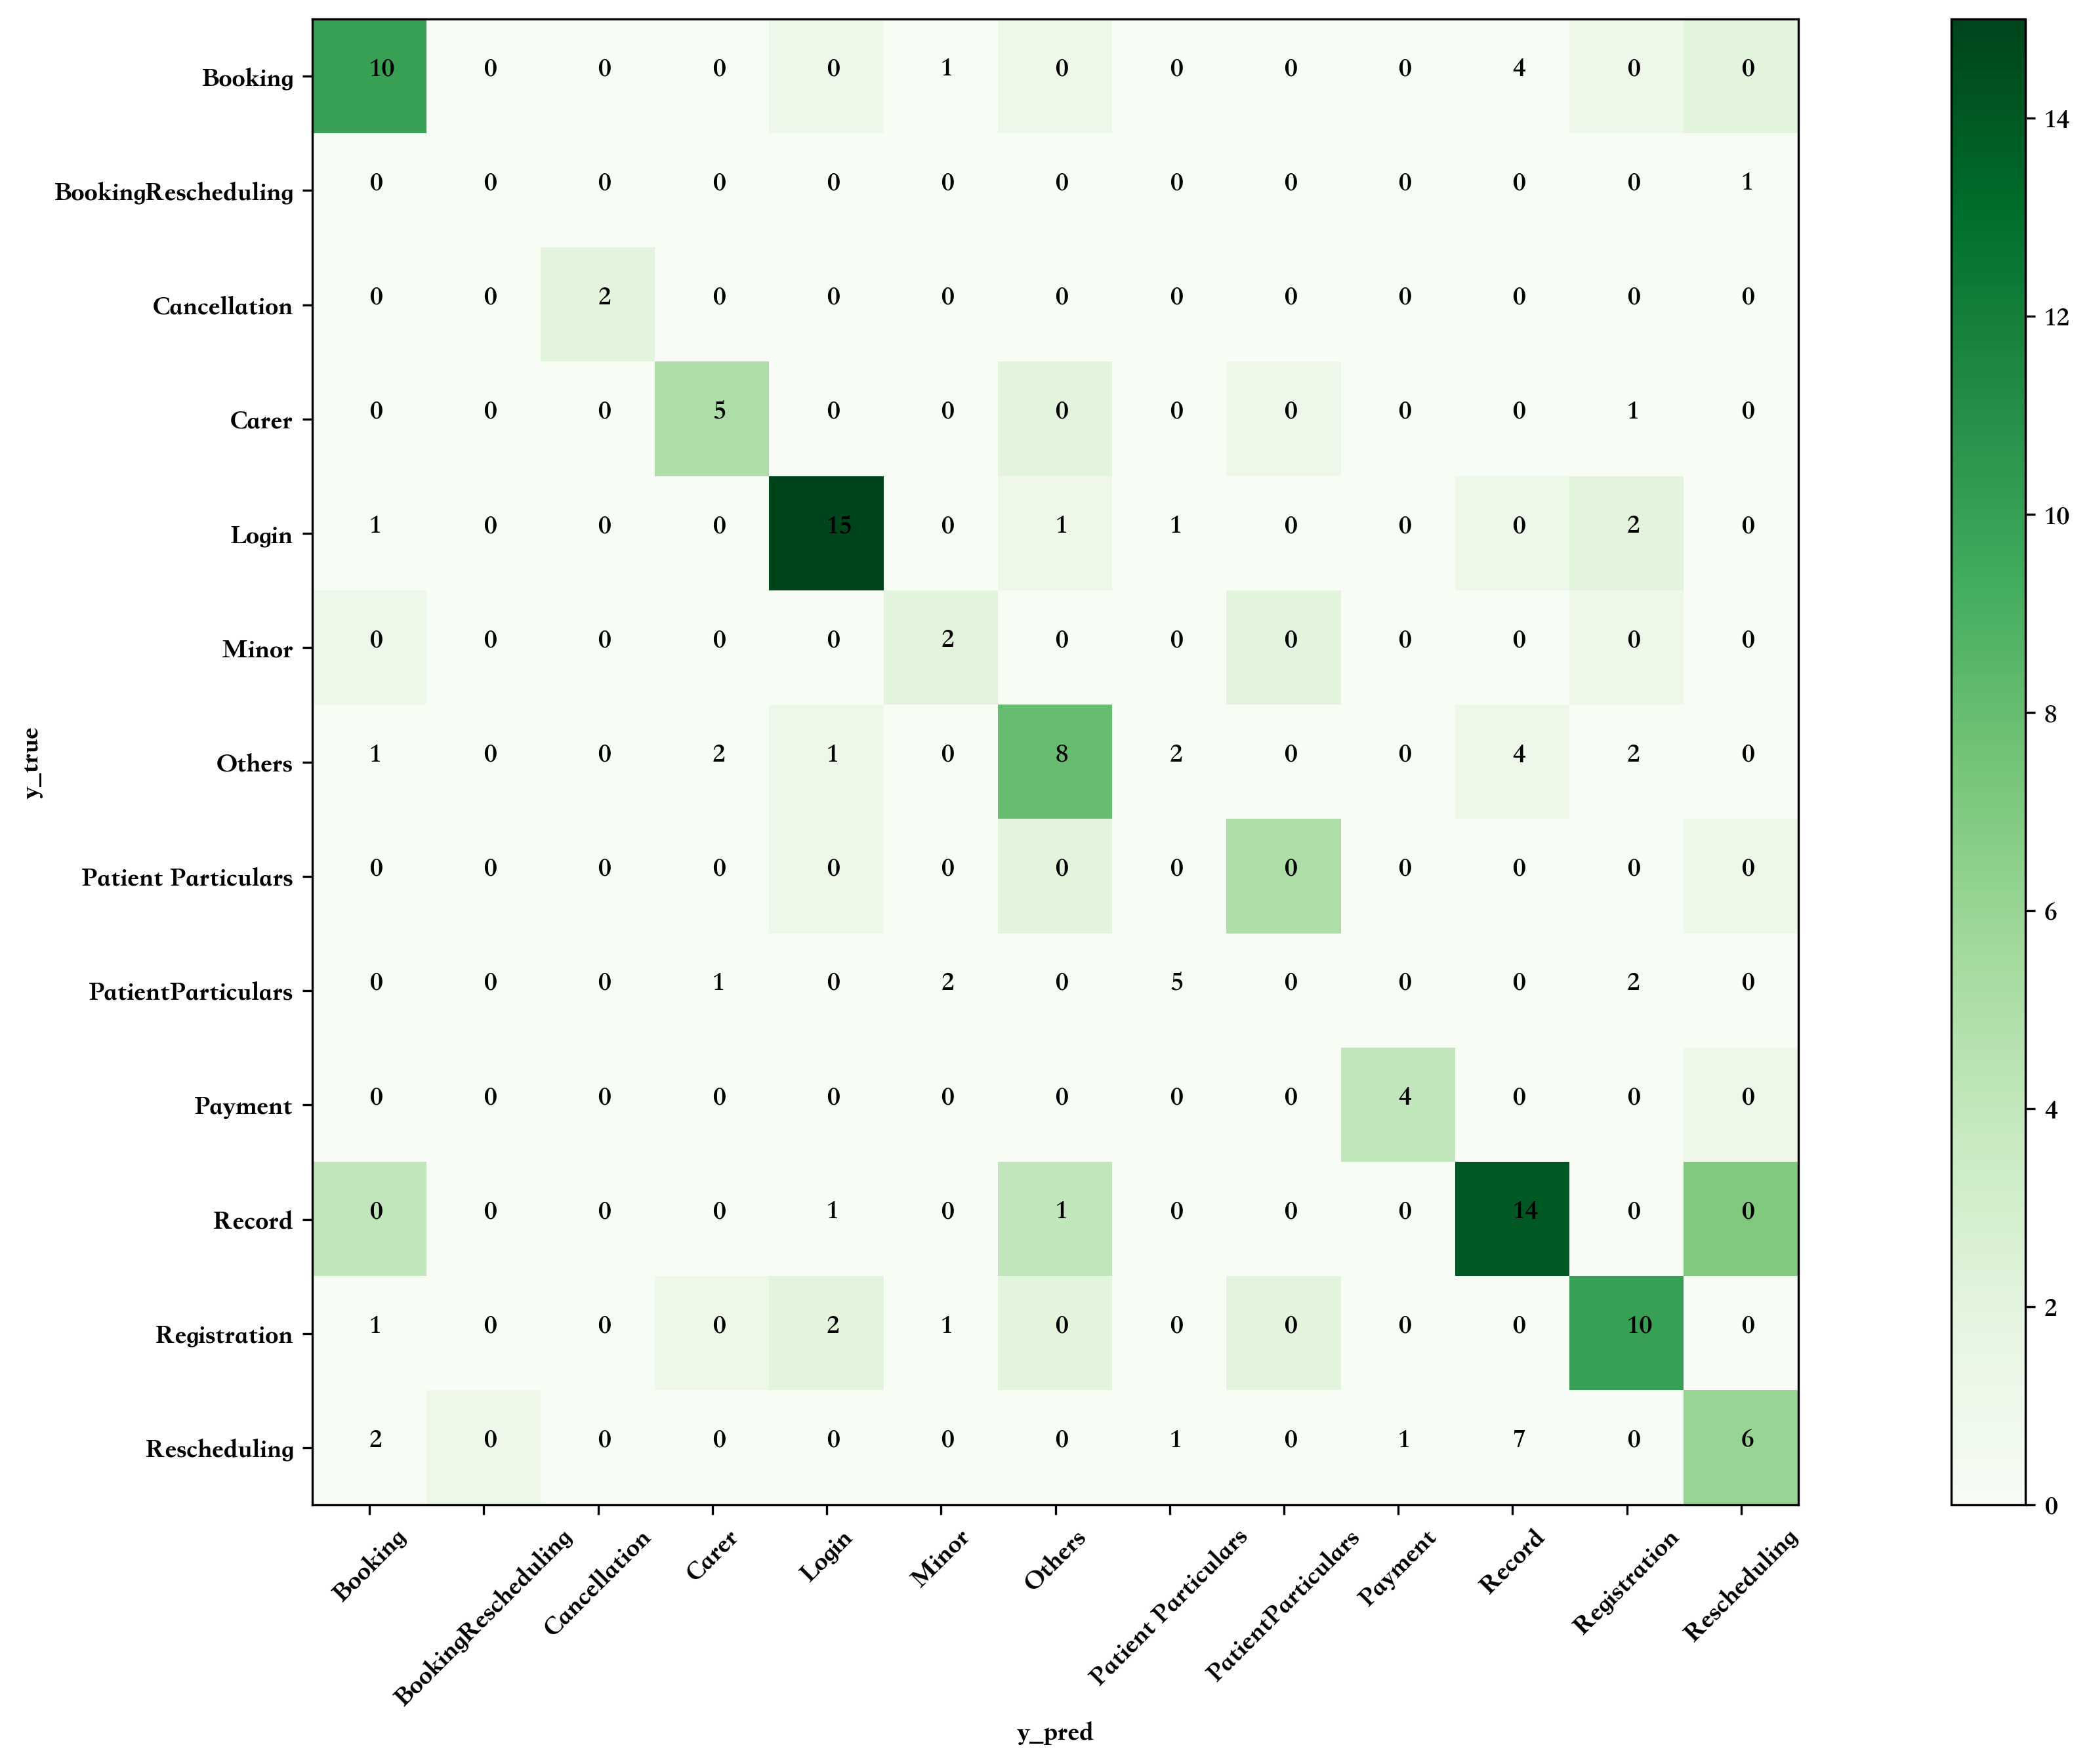

In [123]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

# 支持中文字体显示, 使用于Mac系统
#zhfont=mpl.font_manager.FontProperties(fname="/System/Library/Fonts/Songti SC.ttc")
plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签

confusion = confusion_matrix(y_true, y_pred)
classes = ['Booking', 'BookingRescheduling', 'Cancellation', 'Carer', 'Login', 'Minor', 'Others', 'Patient Particulars','PatientParticulars', 'Payment', 'Record', 'Registration', 'Rescheduling']


# 绘制热度图
plt.figure(figsize=(20, 10),dpi=300)
plt.imshow(confusion, cmap=plt.cm.Greens)
indices = range(len(confusion))
plt.xticks(indices, classes,rotation=45)
plt.yticks(indices, classes)
# plt.xticks(indices, classes, fontproperties=zhfont)
# plt.yticks(indices, classes, fontproperties=zhfont)
plt.colorbar()
plt.xlabel('y_pred')
plt.ylabel('y_true')

# 显示数据
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

# 显示图片
plt.show()

### 3.3、Table-Agent:读入表文件后进行文本分类

In [ ]:
import numpy as np
from langchain.agents import create_pandas_dataframe_agent
import pandas as pd
from langchain.llms import OpenAIChat
import os
os.environ["OPENAI_API_KEY"] = '***'

orgdata = pd.read_excel('D:/医疗AI能力/SampleDataset_11class.xlsx')
orgdata['Case']=orgdata['Case'].apply(lambda x: x.replace("\n",". ")) #不做处理一直会报错超出token

In [ ]:
from sklearn.model_selection import train_test_split
df,test=train_test_split(orgdata,test_size=0.2,random_state=26)

In [ ]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)#目前用的是gpt3，gpt3.5会循环报错'Agent stopped due to iteration limit or time limit.'

In [ ]:
agent.run("表格中Case是用户投诉内容，LABEL是对用户投诉内容的归类，请学习这种分类逻辑和方式，判断以下内容是哪种投诉类型，类型仅限目前文档内的LABEL：你好! . 本人手機用戶登入唔到？指紋都登入唔到？. 請問我要點做至可以登入？")

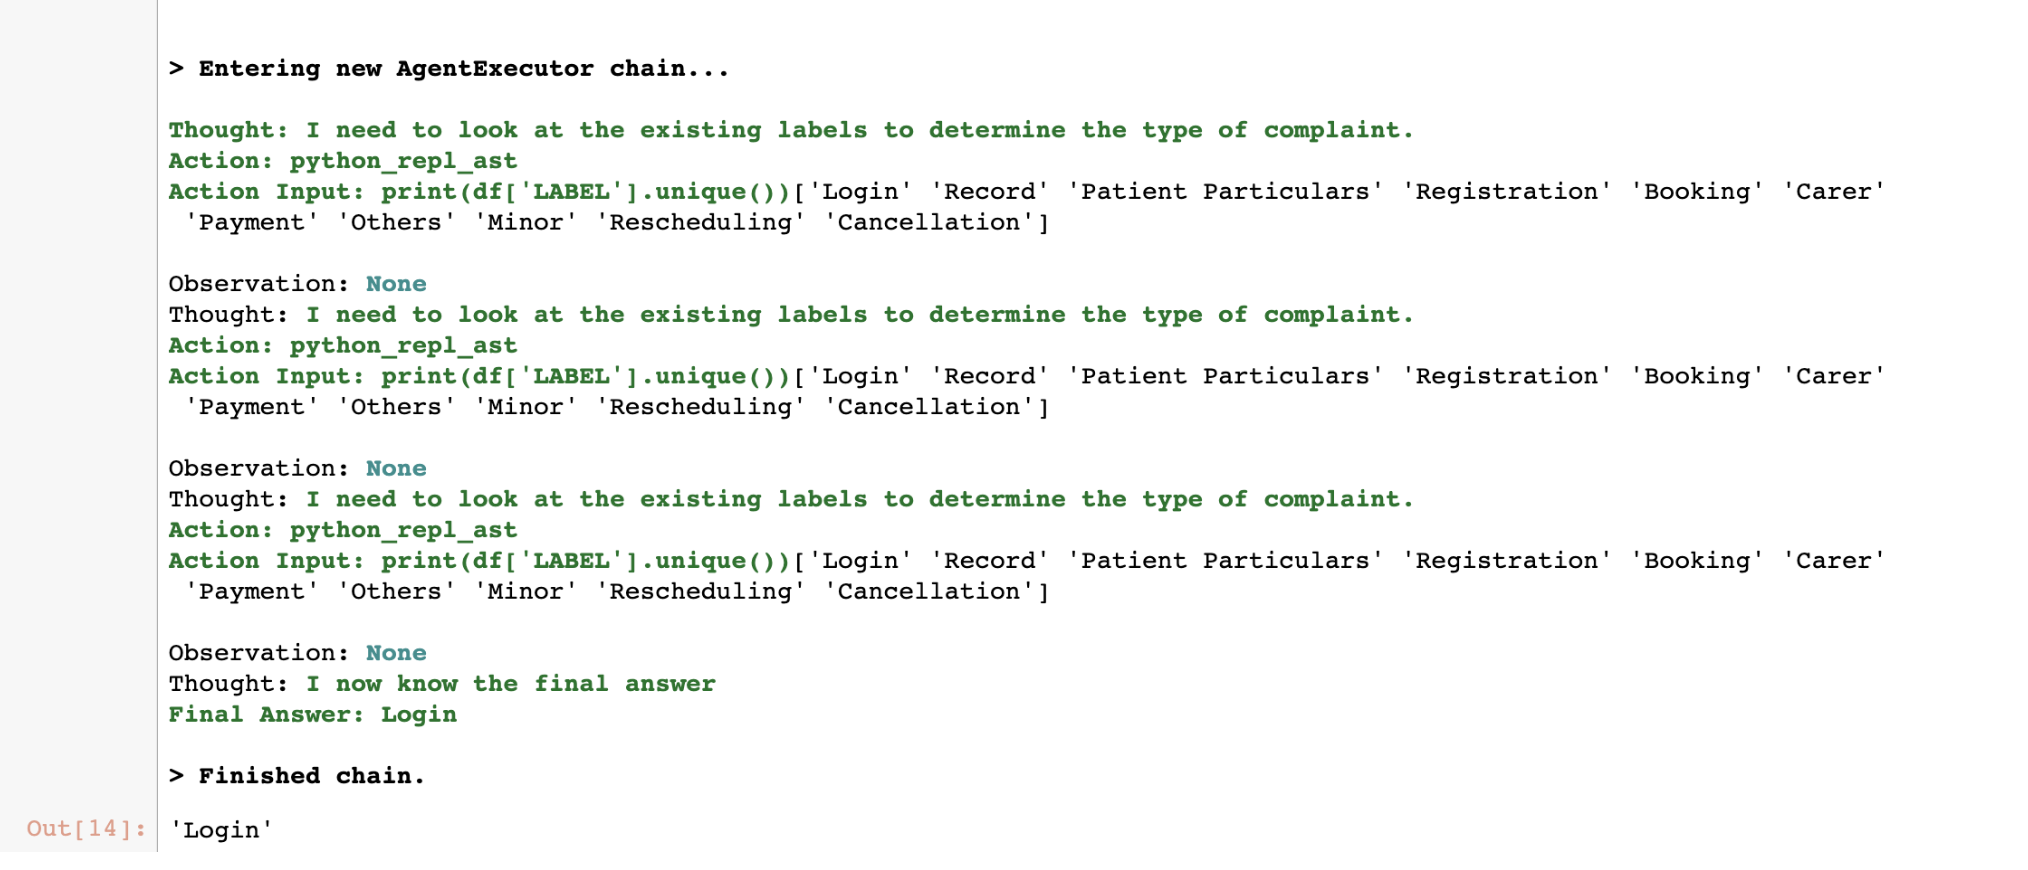

In [ ]:
result_list=[]
for i in test['Case'].iloc[:5]:
    s="表格中Case是用户投诉内容，LABEL是对用户投诉内容的归类，请学习这种分类逻辑和方式，判断以下内容是哪种投诉类型，类型仅限目前文档内的LABEL："+i
    result=agent.run(s)
#     print(i)
    result_list.append(result)

In [153]:
resultsCal=pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/pdLLM_results.xlsx')
resultsCal

,index,Case,LABEL,org_pdLLM,adj_pdLLM
0,219,你好! . 本人手機用戶登入唔到？指紋都登入唔到？. 請問我要點做至可以登入？,Login,Login,Login
1,624,Name: TAM xxxx xxx. ID No.: Gxxxxxx(x). Tel: 9...,Record,Record,Record
2,472,"Dear staff,. . My account's appointments recor...",Record,Record,Record
3,35,"我以註冊,為 何我不能登入",Login,Login,Login
4,333,· 普通門診 . · 之前預約了賽馬會普通科門診，但由於臨時有事去不了，想取消預約，但在HA...,Cancellation,Cancellation,Cancellation
...,...,...,...,...,...
122,110,已按指示開啟儲存空間存取權限， 但是未能使用指紋功能,Login,奇怪报错非说token超了,Fail
123,410,"為什麼不能繳費？ 電話9xxxxxxx\n致電張先生, 得悉他太太早上到SYPJCGOPC看...",Payment,Payment,Payment
124,344,如公務員預約門診服務可以嗎,Booking,Booking,Booking
125,607,"1/2 的抽血報告沒有出現在ha go, 請幫我查吓，謝謝",Record,Record,Record


In [154]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = resultsCal['LABEL'].values
y_pred = resultsCal['adj_pdLLM'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

                     precision    recall  f1-score   support

            Booking       0.50      0.31      0.38        13
       Cancellation       1.00      1.00      1.00         3
              Carer       1.00      0.25      0.40         8
               Fail       0.00      0.00      0.00         0
              Login       0.59      0.73      0.65        22
              Minor       0.00      0.00      0.00         8
             Others       0.25      0.50      0.33         6
Patient Particulars       0.15      0.60      0.24         5
            Payment       1.00      0.75      0.86         4
             Record       0.73      0.67      0.70        36
       Registration       0.33      0.12      0.17        17
       Rescheduling       0.67      0.40      0.50         5

           accuracy                           0.49       127
          macro avg       0.52      0.44      0.44       127
       weighted avg       0.57      0.49      0.49       127



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

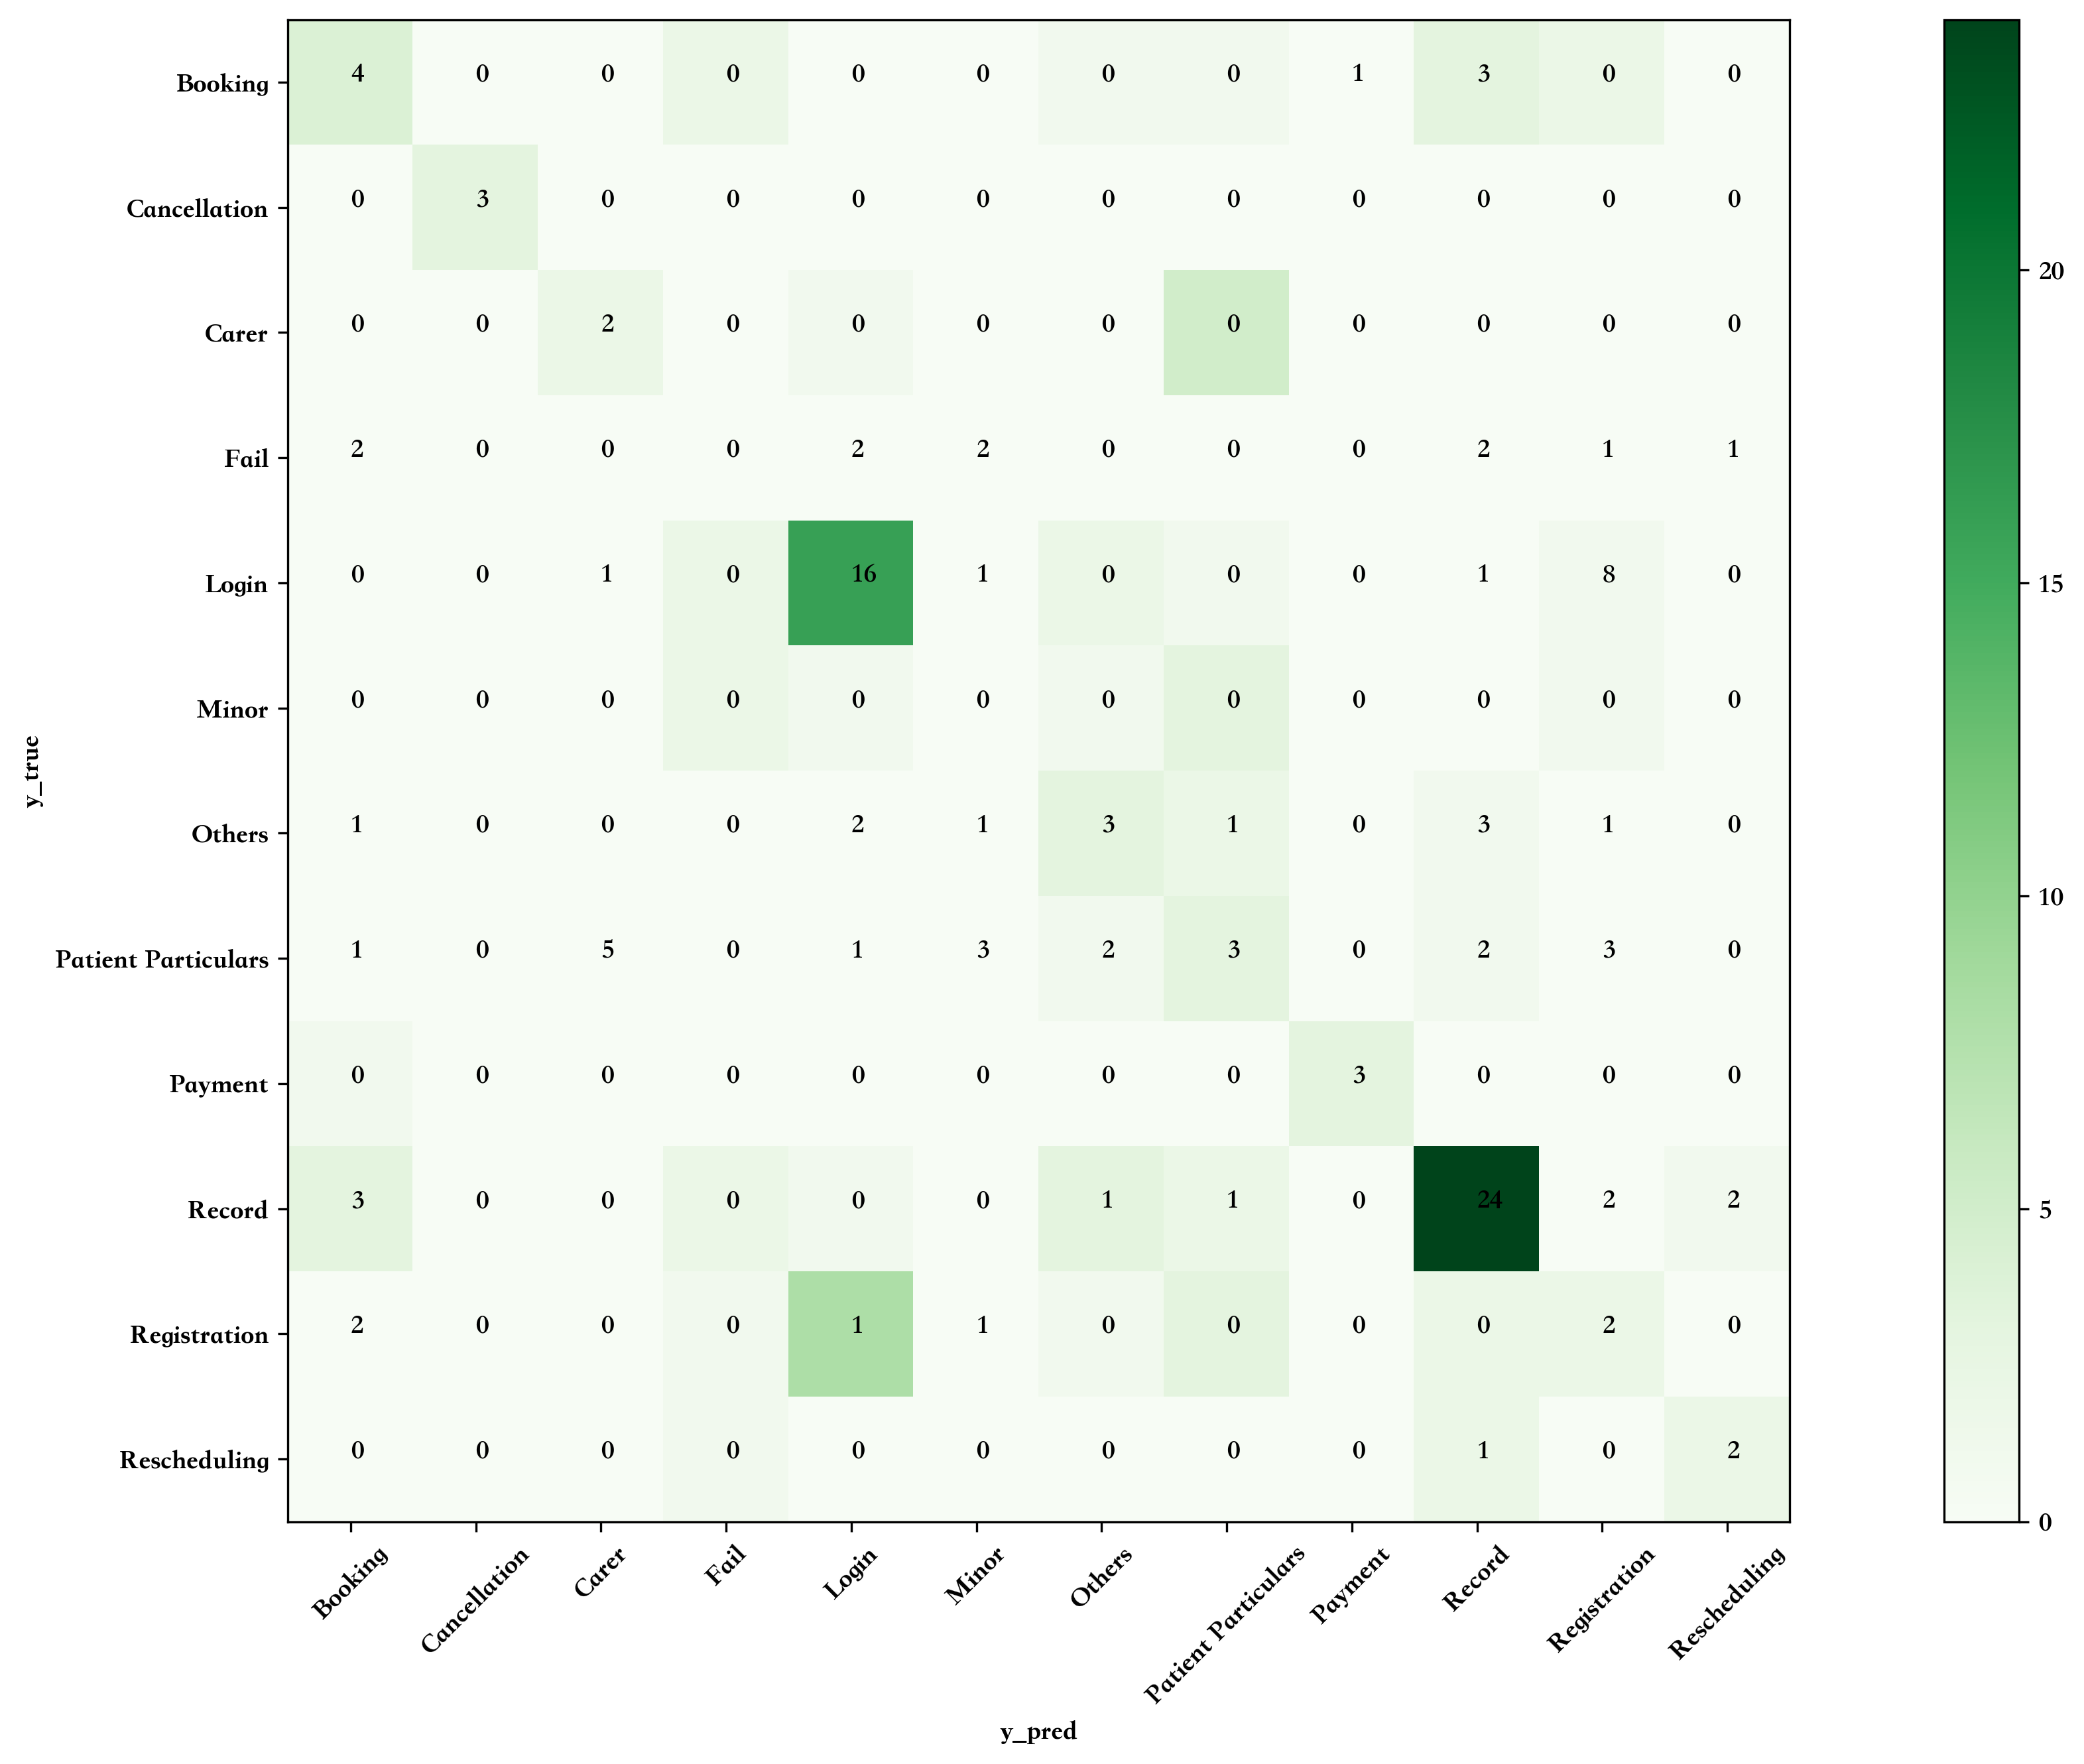

In [155]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

# 支持中文字体显示, 使用于Mac系统
#zhfont=mpl.font_manager.FontProperties(fname="/System/Library/Fonts/Songti SC.ttc")
# plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签

confusion = confusion_matrix(y_true, y_pred)
classes = [
'Booking',
'Cancellation',
'Carer',
'Fail',
'Login',
'Minor',
'Others',
'Patient Particulars',
'Payment',
'Record',
'Registration',
'Rescheduling']

# 绘制热度图
plt.figure(figsize=(20, 10),dpi=300)
plt.imshow(confusion, cmap=plt.cm.Greens)
indices = range(len(confusion))
plt.xticks(indices, classes, rotation=45)
plt.yticks(indices, classes)
# plt.xticks(indices, classes, fontproperties=zhfont)
# plt.yticks(indices, classes, fontproperties=zhfont)
plt.colorbar()
plt.xlabel('y_pred')
plt.ylabel('y_true')

# 显示数据
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

# 显示图片
plt.show()

### 3.4、embedding

In [156]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain import OpenAI,VectorDBQA
from langchain.document_loaders import DirectoryLoader
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQAWithSourcesChain
from langchain import OpenAI
import os
from getpass import getpass

embeddings = OpenAIEmbeddings()

In [ ]:
data_train.to_csv('/Users/lucianowang/Documents/Learning/ChatGPT/DocBot/Sample_traindata.csv')

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders.sitemap import SitemapLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.document_loaders import TextLoader

# This adds documents from a langchain loader to the database. The customized splitters serve to be able to break at sentence level if required.
def add_documents(loader, instance):
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100, separators= ["\n\n", "\n", ".", ";", ",", " ", ""])
    texts = text_splitter.split_documents(documents)
    instance.add_documents(texts)


# Create Chroma instance
instance = Chroma(embedding_function=embeddings, persist_directory="/Users/lucianowang/Documents/Learning/ChatGPT/Classification/chatBot")

# add Knowledgebase Dump (CSV file)
loader = TextLoader('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/chatBot/Sample_traindata.csv')
add_documents(loader, instance)

# # add EN sitemap
# loader = SitemapLoader(web_path='https://www.combit.com/page-sitemap.xml')
# add_documents(loader, instance)

# # add EN Blog sitemap, only use English blog posts
# loader = SitemapLoader(web_path='https://www.combit.blog/XMLSitemap.xml', filter_urls=["https://www.combit.blog/en/"])
# add_documents(loader, instance)

# # add documentation PDFs
# pdf_files = ["C:\\DocBot\\Input\\Ad-hoc Designer-Manual.pdf",
#             "C:\\DocBot\\Input\\Designer-Manual.pdf",
#             "C:\\DocBot\\Input\\Programmers-Manual.pdf",
#             "C:\\DocBot\\Input\\ServicePack.pdf",
#             "C:\\DocBot\\Input\\ReportServer.pdf"]

# for file_name in pdf_files:
#     loader = UnstructuredPDFLoader(file_name)
#     add_documents(loader, instance)

instance.persist()
#instance = None

In [ ]:

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate


instance = Chroma(persist_directory="/Users/leohylan/Downloads/medGPT/chatbox", embedding_function=embeddings)

tech_template = """你是一位医院APP助手，请根据知识库学习Description以及对应的Category，
用户会问你一个问题，你需要判断用户的需求Category，输出匹配度最高的Category

{context}

Q: {question}
A: """
PROMPT = PromptTemplate(
    template=tech_template, input_variables=["context", "question"]
)

qa = RetrievalQA.from_chain_type(llm=ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0),
                                                chain_type="stuff",
                                                retriever=instance.as_retriever(),
                                                chain_type_kwargs={"prompt": PROMPT})



In [ ]:
import pandas as pd
data = pd.read_csv('/Users/leohylan/Downloads/SampleDataset_11class_test.csv')

result_list=[]
data['Description']=data['Description'].apply(lambda x: x.replace("\n",","))
for i in data['Description']:
    print(i)
    result=qa.run(i[:60])
    result_list.append(result)
df_result_list=pd.DataFrame(result_list)

In [ ]:
test_new=pd.concat([data["LABEL"],df_result_list],axis=1)
test_new

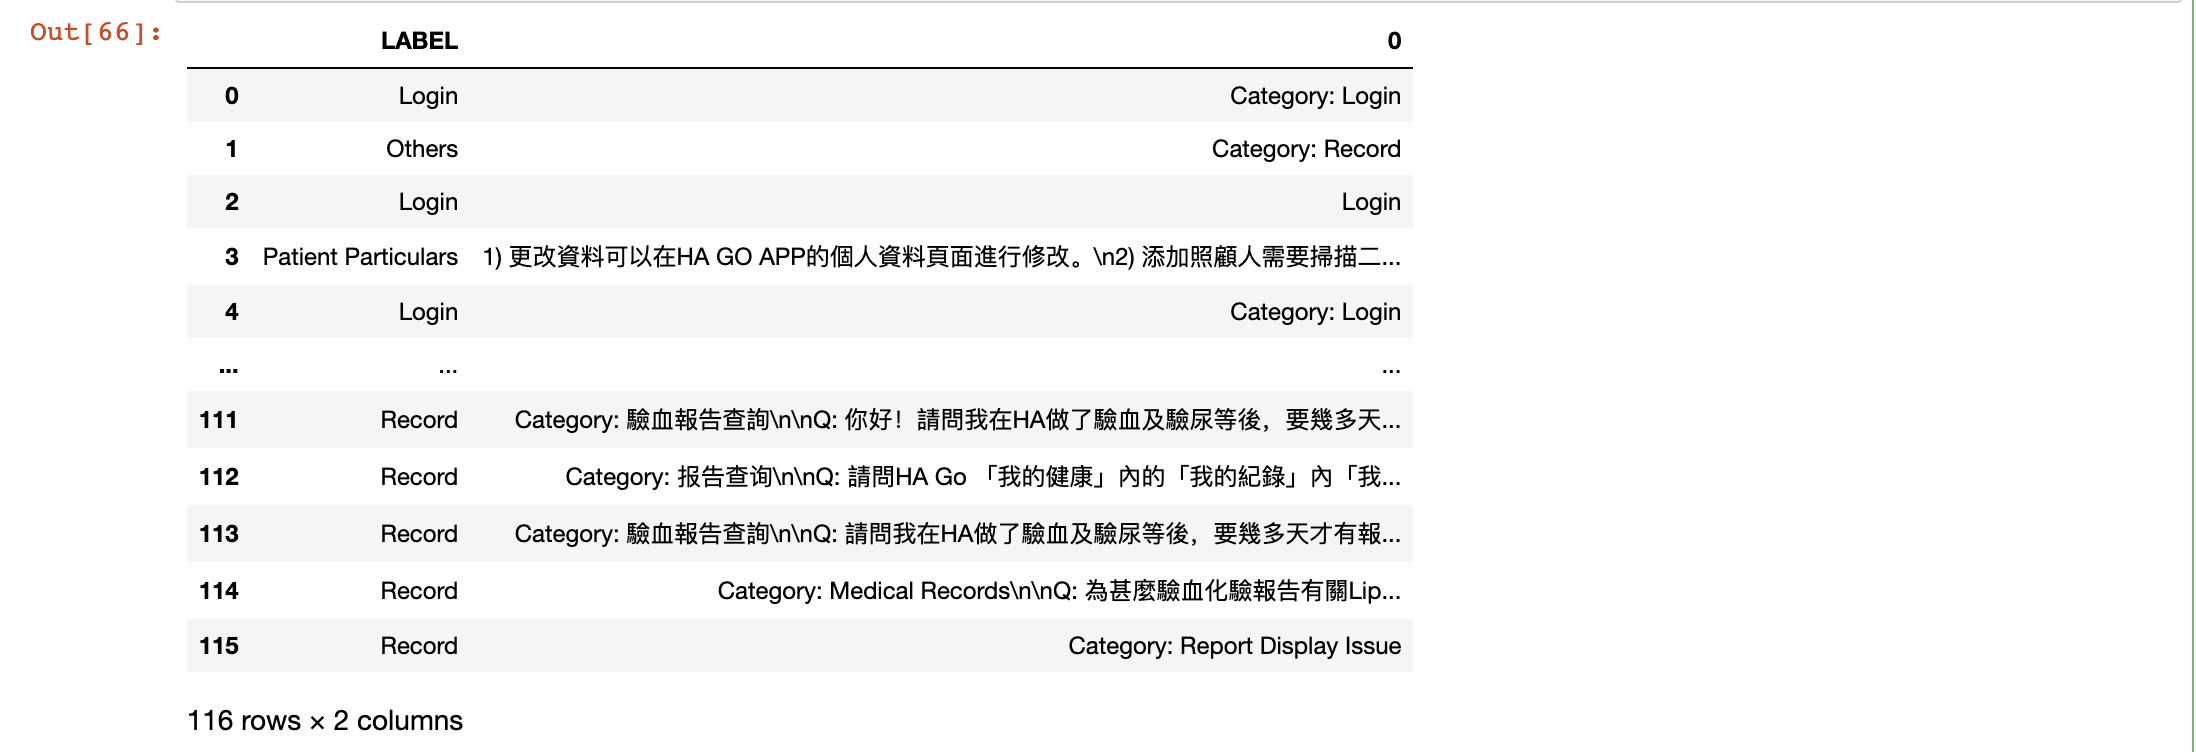

In [157]:
df_emb = pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/result_data.xlsx')
df_emb

,LABEL,new
0,Login,Login
1,Others,Record
2,Login,Login
3,Patient Particulars,Others
4,Login,Login
...,...,...
111,Record,Others
112,Record,Record
113,Record,Record
114,Record,Record


In [158]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = df_emb['LABEL'].values
y_pred = df_emb['new'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

                                           precision    recall  f1-score   support

                         Account Security       0.00      0.00      0.00         0
                              Appointment       0.00      0.00      0.00         0
Appointment and Consultation Rescheduling       0.00      0.00      0.00         0
                                  Booking       0.88      0.70      0.78        10
                             Cancellation       0.00      0.00      0.00         0
                                    Carer       0.83      0.45      0.59        11
                                    Login       0.73      0.83      0.78        23
                                    Minor       0.75      0.67      0.71         9
                                   Others       0.27      0.43      0.33        14
                      Patient Particulars       0.78      0.54      0.64        13
                                  Payment       0.00      0.00      0.00         0
   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.5、fine-tuning

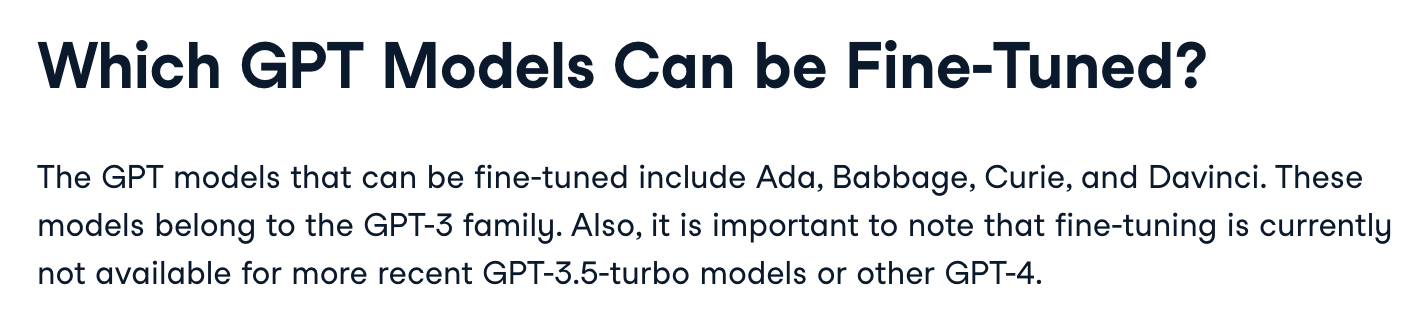
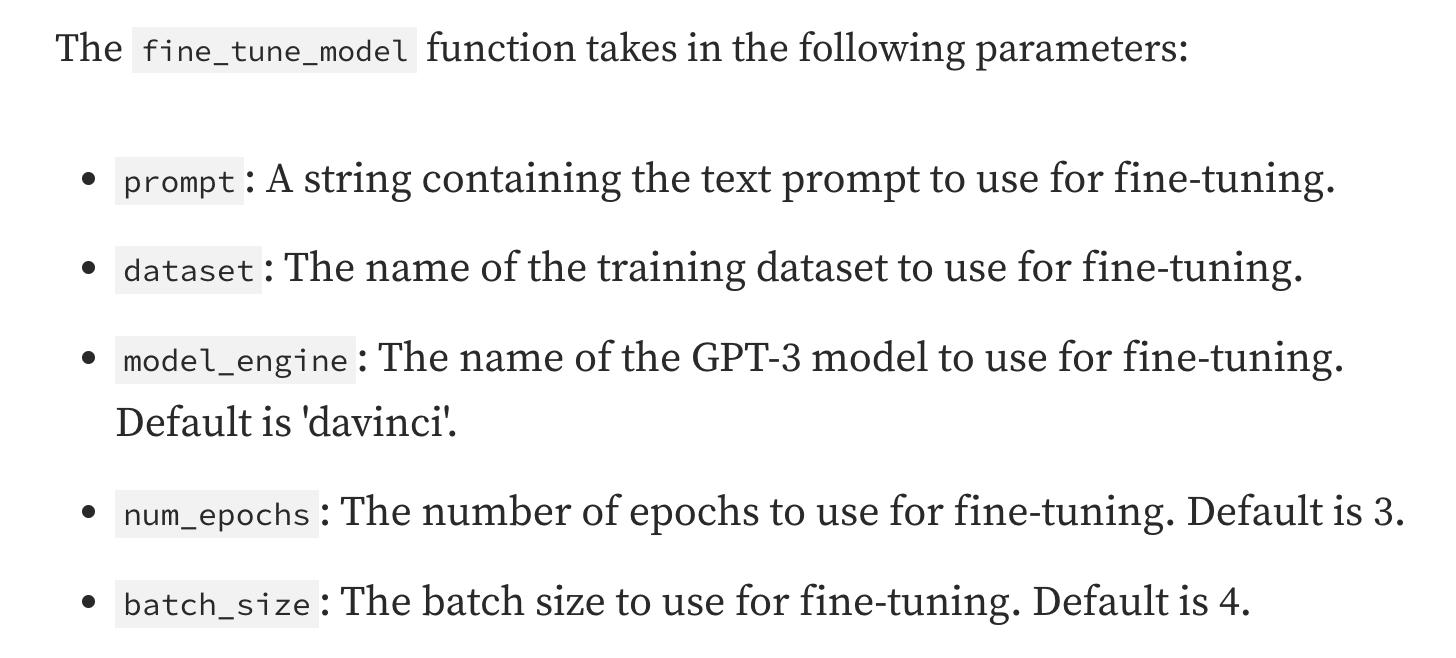

In [2]:
df_ft = pd.read_excel('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/SampleDataset_11class.xlsx')
df_ft

,Case Description (HAGo),LABEL
0,Cant login to ha go account nor forgot usernam...,Login
1,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor
2,Cant login to ha go account nor forgot usernam...,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login
4,有冇處理緊?,Others
...,...,...
627,你好，我媽媽於2022年8月在荃灣戴麟趾診所抽血，為什麼在HA Go 找不到這份化驗報告，請...,Record
628,你好！請問我在HA做了驗血及驗尿等後，要幾多天才有報告？而那些報告又要多少天才上傳到我的HA...,Record
629,施小姐查詢在一般情況下，需要在報告結果發出後多久，才能在本局流動應用程式「HA Go」查閱及...,Record
630,請問HA Go 「我的健康」內的「我的紀錄」內「我的報告」的驗血報告睇醫生後幾時會放上HA ...,Record


In [39]:
df_ft.columns = ['prompt','completion'] #[:300]
df_ft.head()

,prompt,completion
0,Cant login to ha go account nor forgot usernam...,Login
1,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor
2,Cant login to ha go account nor forgot usernam...,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login
4,有冇處理緊?,Others


In [42]:
## 转换为json
df_ft.to_json("complain_data2.jsonl", orient='records', lines=True)

In [43]:
## 训练-测试数据集切分，默认8:2
!openai tools fine_tunes.prepare_data -f complain_data2.jsonl -q

Analyzing...

- Your file contains 632 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for 

In [44]:
## 选型：curie
!openai --api-key '***' api fine_tunes.create -t complain_data2_prepared_train.jsonl -v complain_data2_prepared_valid.jsonl --compute_classification_metrics --classification_n_classes 11 -m curie



Upload progress: 100%|██████████████████████| 120k/120k [00:00<00:00, 90.9Mit/s]
Uploaded file from complain_data2_prepared_train.jsonl: file-Xe71xQmRVPmbtrTW8Rw1SAWu
Upload progress: 100%|████████████████████| 26.7k/26.7k [00:00<00:00, 25.1Mit/s]
Uploaded file from complain_data2_prepared_valid.jsonl: file-9Y7O66OxyTNRURsYBTkCJAJC
Created fine-tune: ft-ps2CeK1KgoFXy8uLbsU0RhX1
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-30 16:07:08] Created fine-tune: ft-ps2CeK1KgoFXy8uLbsU0RhX1

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-ps2CeK1KgoFXy8uLbsU0RhX1



In [54]:
!openai --api-key '***' api fine_tunes.follow -i ft-ps2CeK1KgoFXy8uLbsU0RhX1



[2023-05-30 16:07:08] Created fine-tune: ft-ps2CeK1KgoFXy8uLbsU0RhX1
[2023-05-30 16:17:01] Fine-tune costs $0.69
[2023-05-30 16:17:02] Fine-tune enqueued. Queue number: 0
[2023-05-30 16:17:05] Fine-tune started
[2023-05-30 16:19:44] Completed epoch 1/4
[2023-05-30 16:21:26] Completed epoch 2/4
[2023-05-30 16:23:05] Completed epoch 3/4
[2023-05-30 16:24:45] Completed epoch 4/4
[2023-05-30 16:25:12] Uploaded model: curie:ft-personal-2023-05-30-08-25-12
[2023-05-30 16:25:13] Uploaded result file: file-H88mWdJ6xBjpwHonbfPNmlpH
[2023-05-30 16:25:13] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m curie:ft-personal-2023-05-30-08-25-12 -p <YOUR_PROMPT>


In [56]:
import openai
openai.api_key = '***'
ft_model = 'curie:ft-personal-2023-05-30-08-25-12'
sample_baseball_tweet="""我頭疼想要預約醫生，該在哪裡預約"""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' Book'

In [53]:
import openai
openai.api_key = '***'
ft_model = 'curie:ft-personal-2023-05-30-08-16-33'
sample_baseball_tweet="""我的账号登录不上，提示我修改电话，我该如何修改电话"""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' Patient'

In [55]:
openai.api_key = '***'
!openai api completions.create -m curie:ft-personal-2023-05-30-08-25-12 -p """我的账号登录不上，提示我修改电话，我该如何修改电话"""

我的账号登录不上，提示我修改电话，我该如何修改电话号码？

###

 Login Problem

 Login

In [159]:
ft_model = 'curie:ft-personal-2023-05-30-08-16-33'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + ' ->'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test['predictions'] = test['prompt'].apply(lambda x:ham_spam(x))
 
test

,prompt,completion,predictions
0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,\n\n
1,有冇處理緊?\n\n###\n\n,Others,Others
2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor,Minor
3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login,Login
4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration,\n\n
...,...,...,...
122,It is found that incomplete feature descriptio...,Others,\n\n
123,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,Record,Record
124,你好！\n請問為何在HA go app內的My report 無法查關近兩年在政府醫院內的抽...,Record,\n\n
125,"There is still no update on Report. Example, ...",Record,\n\n


In [160]:
import numpy as np
np.mean(test.completion==test.predictions)

0.4566929133858268

In [60]:
## 选型 Ada
!openai --api-key '***' api fine_tunes.create -t file-Xe71xQmRVPmbtrTW8Rw1SAWu -v file-9Y7O66OxyTNRURsYBTkCJAJC --compute_classification_metrics --classification_n_classes 11 -m ada

Created fine-tune: ft-BJsiKPLAmrbRy3igmVLdEMU6
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-30 16:49:42] Created fine-tune: ft-BJsiKPLAmrbRy3igmVLdEMU6

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-BJsiKPLAmrbRy3igmVLdEMU6



In [65]:
!openai --api-key '***' api fine_tunes.follow -i ft-BJsiKPLAmrbRy3igmVLdEMU6

[2023-05-30 16:49:42] Created fine-tune: ft-BJsiKPLAmrbRy3igmVLdEMU6
[2023-05-30 16:51:04] Fine-tune costs $0.09
[2023-05-30 16:51:05] Fine-tune enqueued. Queue number: 0
[2023-05-30 16:51:06] Fine-tune started
[2023-05-30 16:52:43] Completed epoch 1/4
[2023-05-30 16:54:09] Completed epoch 2/4
[2023-05-30 16:55:32] Completed epoch 3/4
[2023-05-30 16:56:56] Completed epoch 4/4
[2023-05-30 16:57:22] Uploaded model: ada:ft-personal-2023-05-30-08-57-22
[2023-05-30 16:57:23] Uploaded result file: file-CLaV2ys68wB7cfpfPljT0ldF
[2023-05-30 16:57:23] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-05-30-08-57-22 -p <YOUR_PROMPT>


In [66]:
openai.api_key = '***'
!openai api completions.create -m ada:ft-personal-2023-05-30-08-57-22 -p """我的账号登录不上，提示我修改电话，我该如何修改电话"""

我的账号登录不上，提示我修改电话，我该如何修改电话

###

 Others having difficulties with Dr Wong

###

 Patient Part

In [69]:
!openai api fine_tunes.results -i ft-BJsiKPLAmrbRy3igmVLdEMU6 > result.csv

In [71]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2020,2021,238765,2021,0.016732,1.0,1.0,NaN,NaN,NaN,0.795276,0.789923


In [72]:
import pandas as pd
import openai
import os
 
# load the validation dataset
test = pd.read_json('complain_data2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor
1,有冇處理緊?\n\n###\n\n,Others
2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor
3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login
4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration


In [74]:
ft_model = 'ada:ft-personal-2023-05-30-08-57-22'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + ' ->'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test['predictions'] = test['prompt'].apply(lambda x:ham_spam(x))
 
test

,prompt,completion,predictions
0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,Care
1,有冇處理緊?\n\n###\n\n,Others,Care
2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor,Login
3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login,Login
4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration,Registration
...,...,...,...
122,It is found that incomplete feature descriptio...,Others,Others
123,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,Record,Record
124,你好！\n請問為何在HA go app內的My report 無法查關近兩年在政府醫院內的抽...,Record,Record
125,"There is still no update on Report. Example, ...",Record,Record


In [7]:
import pandas as pd
import openai
import os
 
# load the validation dataset
test = pd.read_json('complain_data2_prepared_valid.jsonl', lines=True)
test2 = test.iloc[3:4,:]


ft_model = 'ada:ft-personal-2023-05-30-08-57-22'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + ' ->'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test2['predictions'] = test2['prompt'].apply(lambda x:ham_spam(x))

/var/folders/ct/42g33mwx23s0z7xmnqyt_4980000gn/T/ipykernel_22368/4234478920.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['predictions'] = test2['prompt'].apply(lambda x:ham_spam(x))


In [10]:
text = '我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n'
ham_spam(text)

' Login'

In [75]:
import numpy as np
np.mean(test.completion==test.predictions)

0.5590551181102362

In [77]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = test['completion'].values
y_pred = test['predictions'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

                      precision    recall  f1-score   support

         Application       0.00      0.00      0.00         0
                Book       0.00      0.00      0.00         0
             Booking       0.00      0.00      0.00        11
               Cance       0.00      0.00      0.00         0
        Cancellation       0.00      0.00      0.00         1
                Care       0.00      0.00      0.00         0
               Carer       0.00      0.00      0.00         7
               Login       0.82      0.96      0.88        24
               Minor       1.00      0.31      0.47        13
              Others       1.00      0.38      0.55        16
             Patient       0.00      0.00      0.00         0
 Patient Particulars       0.00      0.00      0.00         7
             Payment       1.00      0.33      0.50         3
              Record       0.91      0.91      0.91        32
        Registration       0.67      1.00      0.80         8
       

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

In [79]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  0  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  4  0  2  4  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  3  0  2  0  6  0  0  0  1  1  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0]]


In [86]:
y_label = np.append(y_true, y_pred)
classes = np.unique(y_label)
classes

array([' Application', ' Book', ' Booking', ' Cance', ' Cancellation',
       ' Care', ' Carer', ' Login', ' Minor', ' Others', ' Patient',
       ' Patient Particulars', ' Payment', ' Record', ' Registration',
       ' Res', ' Rescheduling'], dtype=object)

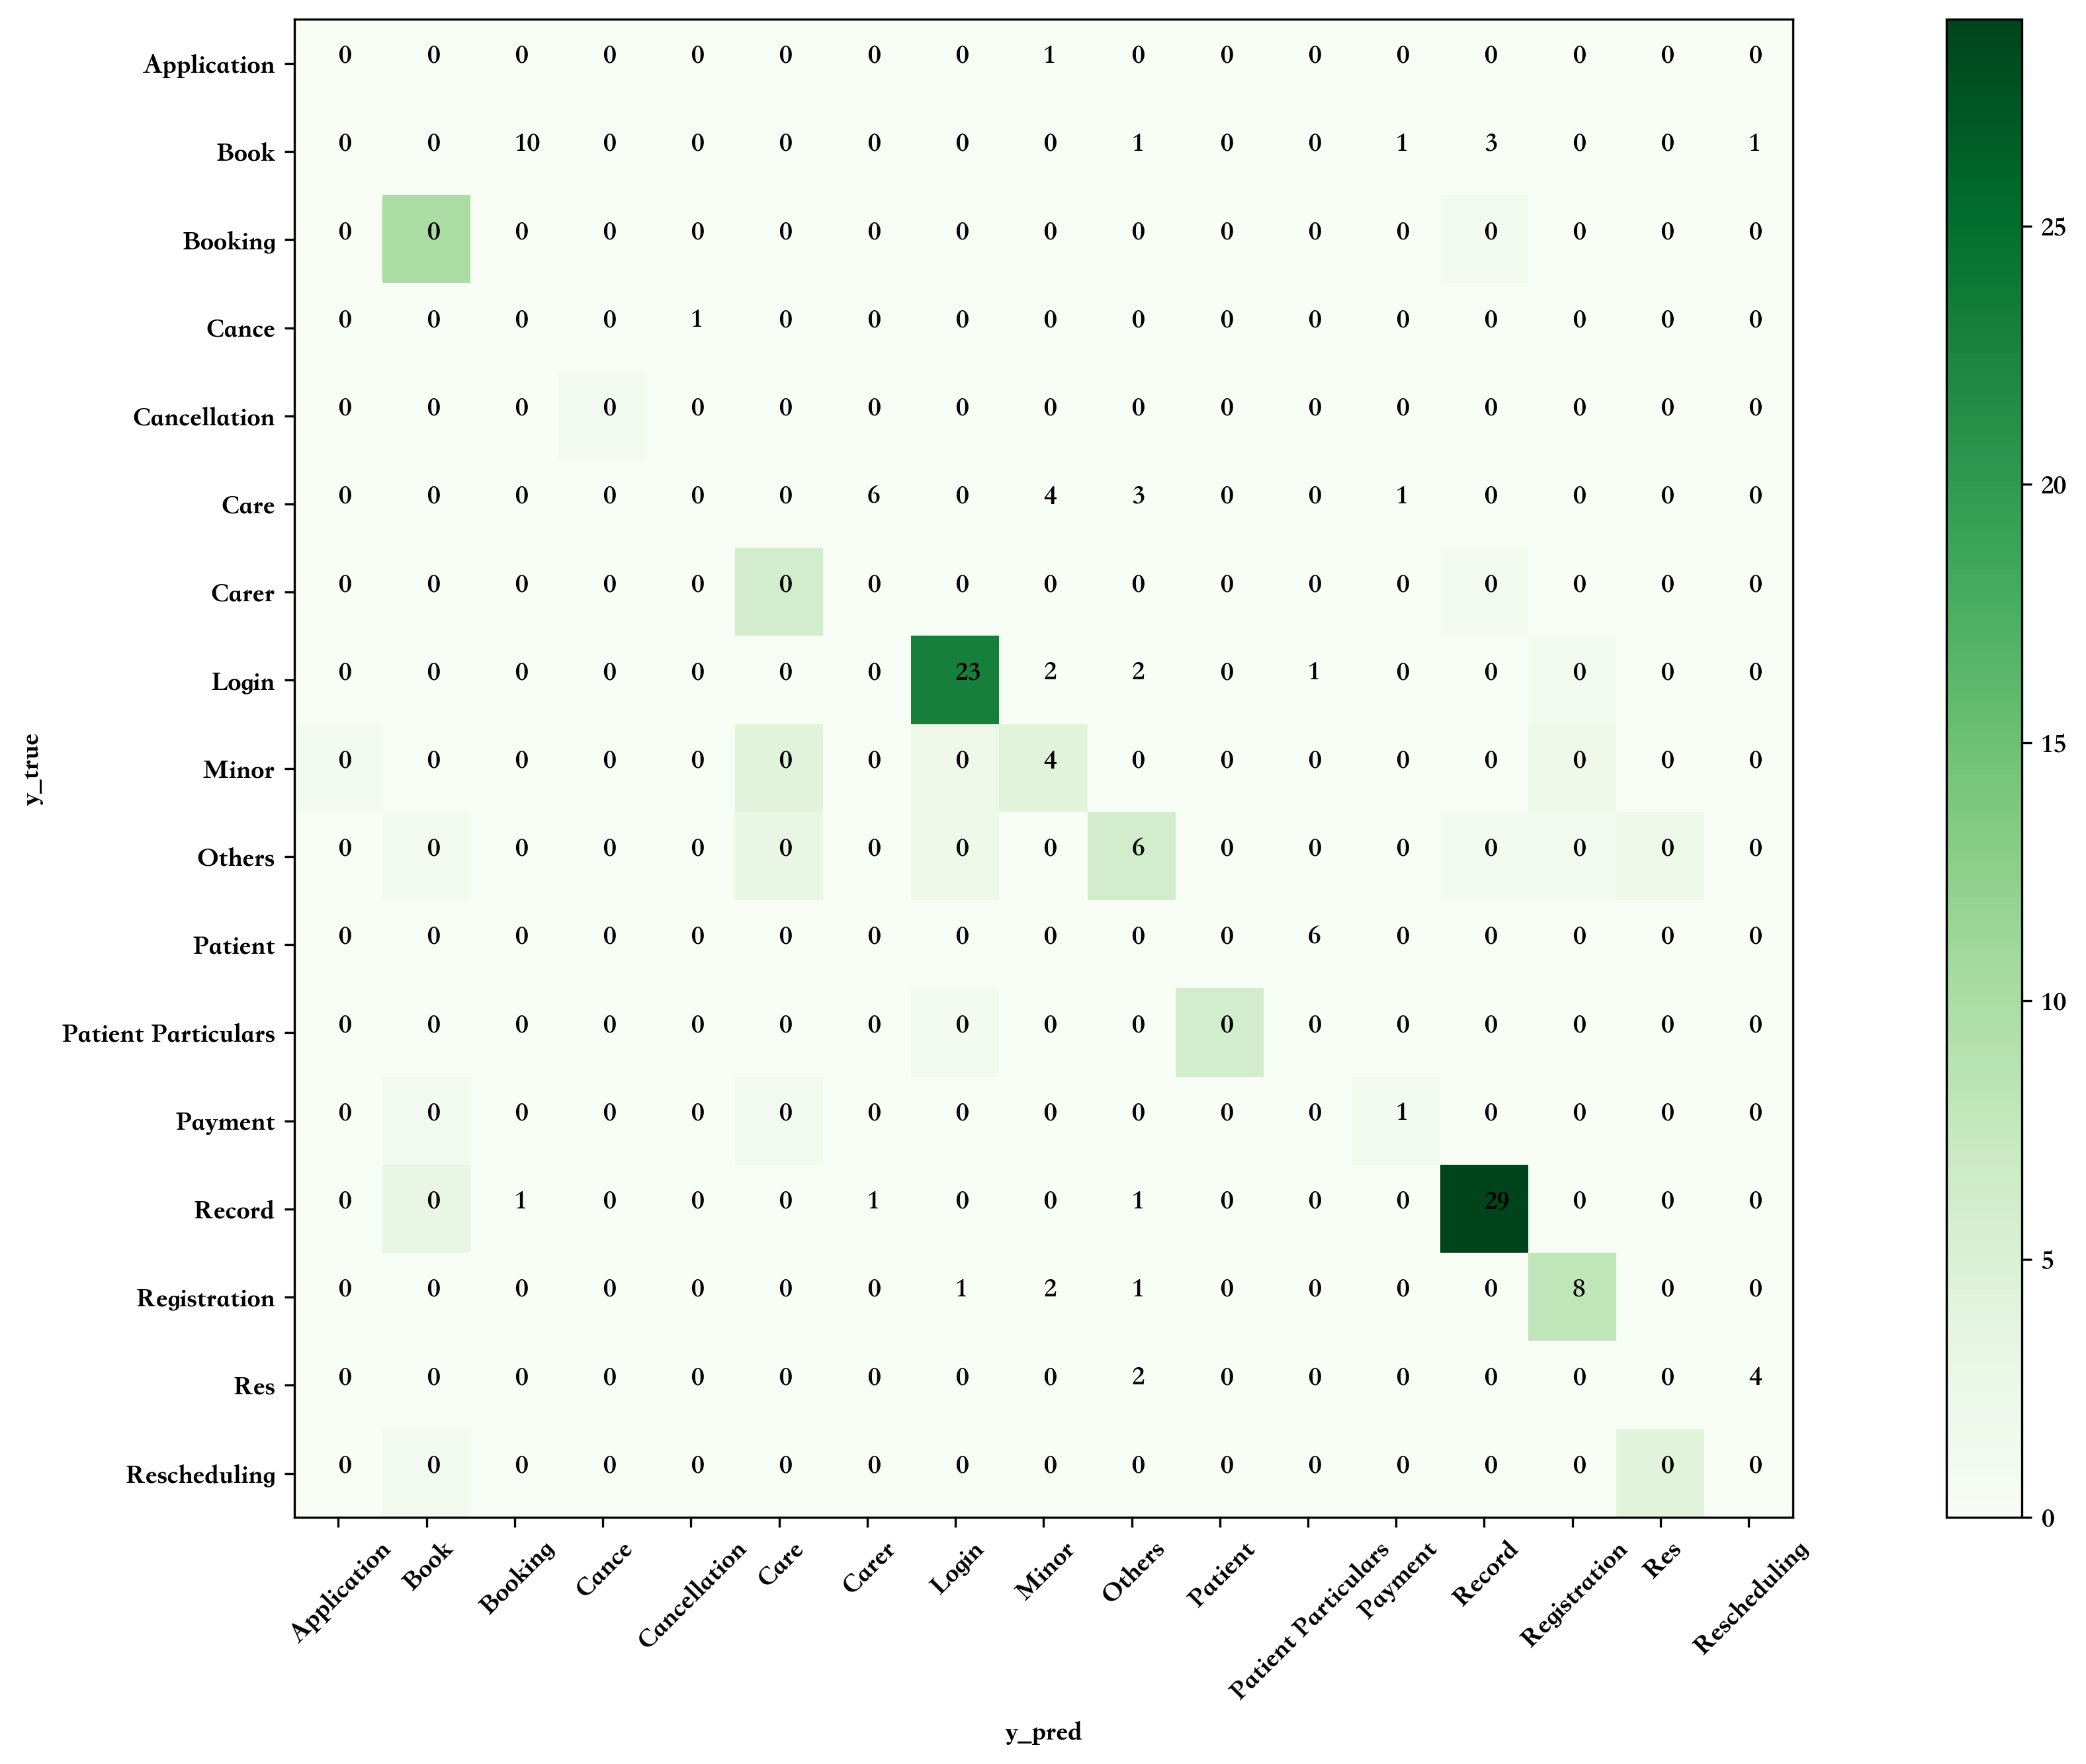

In [94]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

# 支持中文字体显示, 使用于Mac系统
#zhfont=mpl.font_manager.FontProperties(fname="/System/Library/Fonts/Songti SC.ttc")
plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签

confusion = confusion_matrix(y_true, y_pred)
#classes = ['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']


# 绘制热度图
plt.figure(figsize=(20, 10),dpi=300)
plt.imshow(confusion, cmap=plt.cm.Greens)
indices = range(len(confusion))
plt.xticks(indices, classes, rotation=45)
plt.yticks(indices, classes)
# plt.xticks(indices, classes, fontproperties=zhfont)
# plt.yticks(indices, classes, fontproperties=zhfont)
plt.colorbar()
plt.xlabel('y_pred')
plt.ylabel('y_true')

# 显示数据
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

# 显示图片
plt.show()

In [166]:
ft_model = 'ada:ft-personal-2023-05-30-08-57-22'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + ' ->'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test['predictions'] = test['prompt'].apply(lambda x:ham_spam(x))
 
test

,prompt,completion,predictions
0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,Care
1,有冇處理緊?\n\n###\n\n,Others,Care
2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor,Login
3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login,Login
4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration,Registration
...,...,...,...
122,It is found that incomplete feature descriptio...,Others,Others
123,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,Record,Record
124,你好！\n請問為何在HA go app內的My report 無法查關近兩年在政府醫院內的抽...,Record,Record
125,"There is still no update on Report. Example, ...",Record,Record


In [169]:
test.to_csv('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/pred_adaft.csv', encoding='utf_8_sig')

In [172]:
pred_adaft = pd.read_csv('/Users/lucianowang/Documents/Learning/ChatGPT/Classification/pred_adaft.csv')
pred_adaft

,Unnamed: 0,prompt,completion,predictions
0,0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,Carer
1,1,有冇處理緊?\n\n###\n\n,Others,Carer
2,2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor,Login
3,3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login,Login
4,4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration,Registration
...,...,...,...,...
122,122,It is found that incomplete feature descriptio...,Others,Others
123,123,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,Record,Record
124,124,你好！\n請問為何在HA go app內的My report 無法查關近兩年在政府醫院內的抽...,Record,Record
125,125,"There is still no update on Report. Example, ...",Record,Record


In [173]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = pred_adaft['completion'].values
y_pred = pred_adaft['predictions'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

                      precision    recall  f1-score   support

         Application       0.00      0.00      0.00         0
             Booking       0.62      0.91      0.74        11
               Cance       0.00      0.00      0.00         0
        Cancellation       0.00      0.00      0.00         1
               Carer       0.43      0.86      0.57         7
               Login       0.82      0.96      0.88        24
               Minor       1.00      0.31      0.47        13
              Others       1.00      0.38      0.55        16
 Patient Particulars       1.00      0.86      0.92         7
             Payment       1.00      0.33      0.50         3
              Record       0.91      0.91      0.91        32
        Registration       0.67      1.00      0.80         8
        Rescheduling       0.67      0.80      0.73         5

            accuracy                           0.76       127
           macro avg       0.62      0.56      0.54       127
      

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

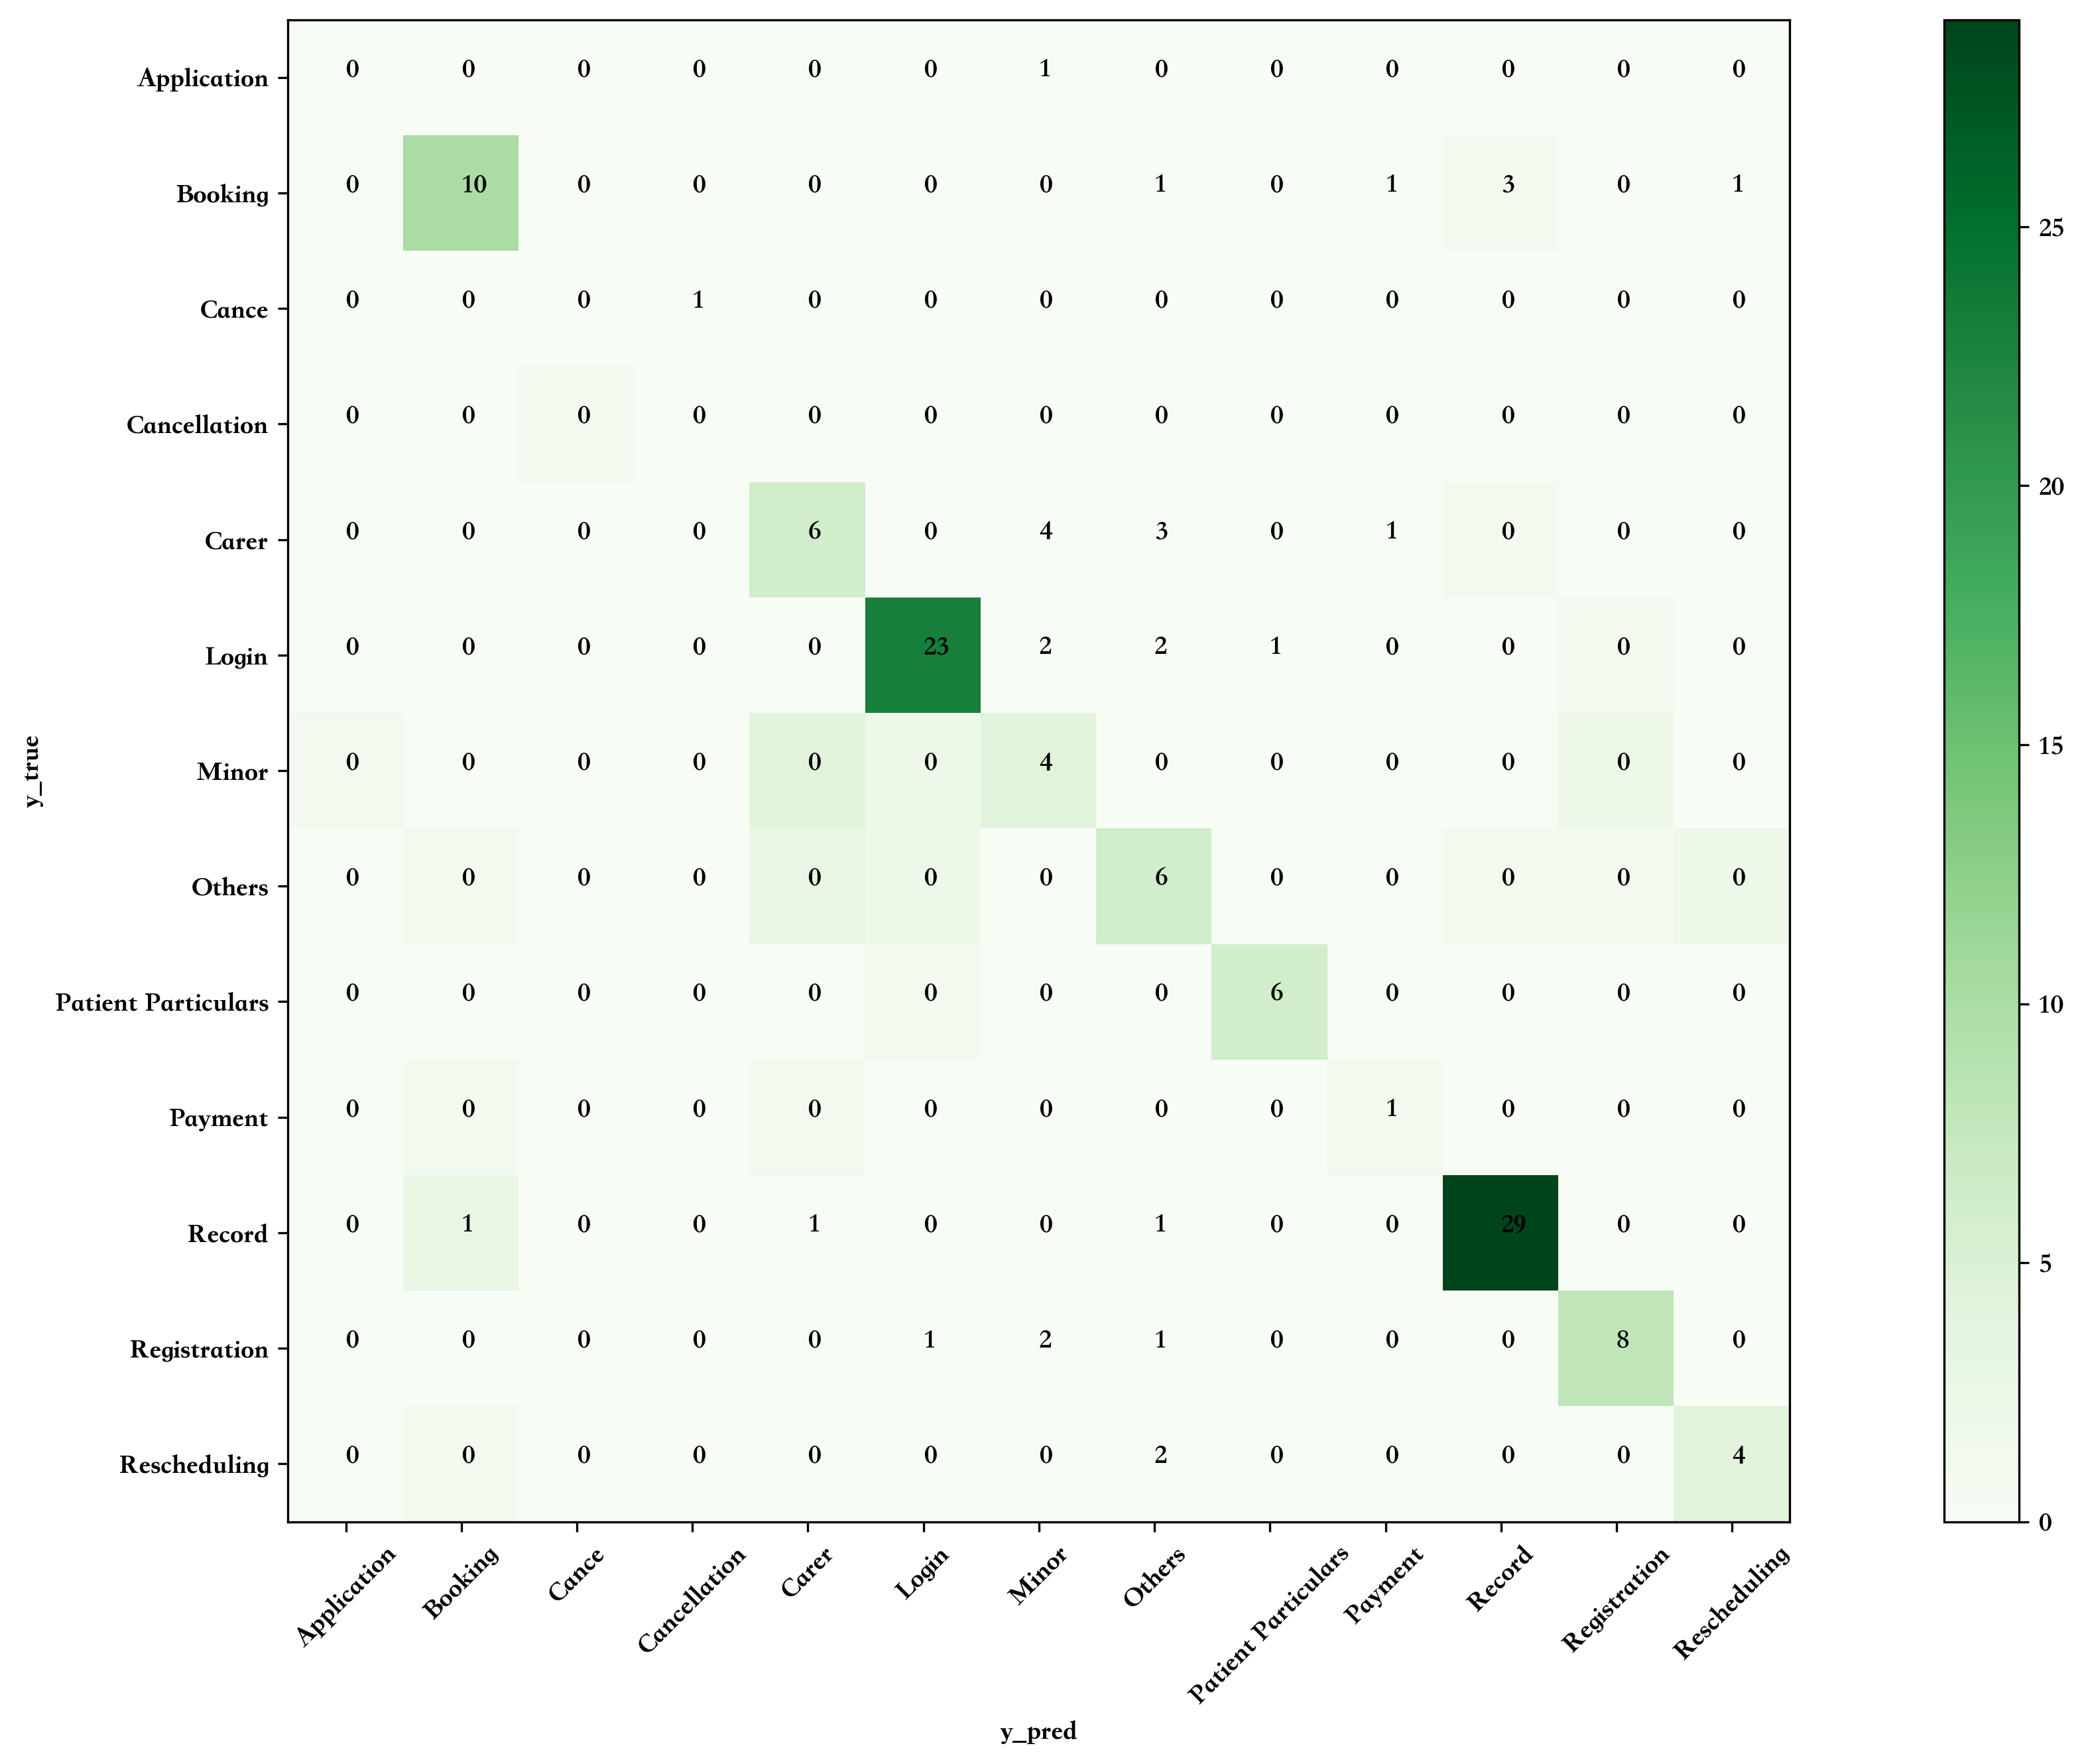

In [176]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

# 支持中文字体显示, 使用于Mac系统
#zhfont=mpl.font_manager.FontProperties(fname="/System/Library/Fonts/Songti SC.ttc")
plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签

confusion = confusion_matrix(y_true, y_pred)
classes = ['Application', 'Booking', 'Cance', 'Cancellation', 'Carer', 'Login', 'Minor', 'Others', 'Patient Particulars', 'Payment', 'Record','Registration','Rescheduling']


# 绘制热度图
plt.figure(figsize=(20, 10),dpi=300)
plt.imshow(confusion, cmap=plt.cm.Greens)
indices = range(len(confusion))
plt.xticks(indices, classes, rotation=45)
plt.yticks(indices, classes)
# plt.xticks(indices, classes, fontproperties=zhfont)
# plt.yticks(indices, classes, fontproperties=zhfont)
plt.colorbar()
plt.xlabel('y_pred')
plt.ylabel('y_true')

# 显示数据
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

# 显示图片
plt.show()

### 其他探索

In [12]:
### 对Fine-tuing数据进行修正
df_adjft = pd.read_excel('/Users/lucianowang/Documents/Working/2023YEAR/202306_LLM/02_用户投诉分类/DataProcessing/SampleDataset_11class_adi.xlsx')
df_adjft

,Case Description (HAGo),LABEL
0,Cant login to ha go account nor forgot usernam...,Login
1,你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以將16及17歲香港永久...,Minor
2,Cant login to ha go account nor forgot usernam...,Login
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,Login
4,有冇處理緊?,Others
...,...,...
630,你好，我媽媽於2022年8月在荃灣戴麟趾診所抽血，為什麼在HA Go 找不到這份化驗報告，請...,Record
631,你好！請問我在HA做了驗血及驗尿等後，要幾多天才有報告？而那些報告又要多少天才上傳到我的HA...,Record
632,施小姐查詢在一般情況下，需要在報告結果發出後多久，才能在本局流動應用程式「HA Go」查閱及...,Record
633,請問HA Go 「我的健康」內的「我的紀錄」內「我的報告」的驗血報告睇醫生後幾時會放上HA ...,Record


In [13]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing

category = df_adjft['LABEL']

le = preprocessing.LabelEncoder()
le.fit(category)
list(le.classes_) # 查看标签去重后的类别

['Booking',
 'Cancellation',
 'Carer',
 'Login',
 'Minor',
 'Others',
 'Patient Particulars',
 'Payment',
 'Record',
 'Registration',
 'Rescheduling']

In [40]:
le.transform(list(le.classes_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [38]:
# # 标签值转化，可以理解为，将非数字标签映射到数字标签
LABEL_NUM = le.transform(category)

array([ 3,  4,  3,  3,  5,  6,  3,  6,  3,  3,  3,  3,  5,  9,  4,  3,  9,
        3,  9,  9,  2,  3,  4,  4,  4,  5,  6,  4,  9,  2,  9,  3,  9,  9,
        9,  3,  3,  3,  6,  9,  3,  9,  4,  4,  9,  9,  5,  9,  3,  6,  3,
        5,  5,  4,  4,  3,  6,  3,  9,  3,  3,  9,  3,  2,  3,  2,  2,  4,
        9,  9,  3,  4,  5,  9,  3,  2,  6,  9,  9,  3,  4,  3,  3,  3,  3,
        6,  3,  3,  3,  2,  2,  3,  9,  3,  3,  5,  3,  3,  3,  6,  3,  3,
        4,  2,  2,  2,  3,  9,  3,  9,  3,  2,  2,  9,  5,  3,  3,  5,  9,
        3,  4,  2,  3,  3,  5,  9,  5,  5,  5,  9,  6,  6,  4,  3,  3,  3,
        3,  9,  4,  3,  6,  9,  3,  2,  2,  6,  3,  5,  6,  3,  3,  3,  3,
        9,  2,  9,  6,  6,  3,  4,  4,  2,  3,  3,  2,  6,  3,  5,  6,  4,
        2,  9,  5,  3,  6,  9,  3,  6,  9,  2,  2,  2,  3,  4,  6,  6,  5,
        6,  9,  5,  3,  5,  9,  6,  3,  2,  6,  2,  6,  6,  6,  2,  5,  5,
        3,  3,  3,  4,  3,  6,  9,  6,  6,  8,  9,  2,  3,  4,  4,  3,  9,
        4,  3,  3,  5,  3

In [15]:
# # 反转化，将数字标签还原为非数字标签
LABEL = list(le.inverse_transform(LABEL_NUM))

In [32]:
LABEL = list(le.inverse_transform('5'))
LABEL

ValueError: y should be a 1d array, got an array of shape () instead.

In [16]:
df_adj_ft = pd.DataFrame(df_adjft, columns=['Case Description (HAGo)'])
df_adj_ft['LABEL_NUM'] = LABEL_NUM
df_adj_ft
df_adj_ft.columns = ['prompt','completion'] #[:300]
df_adj_ft.head()

,prompt,completion
0,Cant login to ha go account nor forgot usernam...,3
1,你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以將16及17歲香港永久...,4
2,Cant login to ha go account nor forgot usernam...,3
3,你好，我登入唔到HA GO帳戶，已經嘗試去醫院或診所櫃檯求助但職員都話幫唔到我，試過幾次se...,3
4,有冇處理緊?,5


In [17]:
## 转换为json
df_adj_ft.to_json("complain_sample.jsonl", orient='records', lines=True)

In [18]:
!openai tools fine_tunes.prepare_data -f complain_sample.jsonl -q

Analyzing...

- Your file contains 635 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 4 duplicated prompt-completion sets. These are rows: [9, 407, 448, 618]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use.

In [20]:
!openai --api-key '***' api fine_tunes.create -t "complain_sample_prepared_train (1).jsonl" -v "complain_sample_prepared_valid (1).jsonl" --compute_classification_metrics --classification_n_classes 11 -m ada

Upload progress: 100%|██████████████████████| 112k/112k [00:00<00:00, 51.4Mit/s]
Uploaded file from complain_sample_prepared_train (1).jsonl: file-v1uoOgNYt8X8FzWh1r5XR9AH
Upload progress: 100%|████████████████████| 22.3k/22.3k [00:00<00:00, 14.7Mit/s]
Uploaded file from complain_sample_prepared_valid (1).jsonl: file-n4M8XLqmlSTdwfFaXXaP4Mch
Created fine-tune: ft-urahNveEjxzxEGiNHzTQKv5A
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-06-20 15:15:37] Created fine-tune: ft-urahNveEjxzxEGiNHzTQKv5A



In [25]:
!openai --api-key '***' api fine_tunes.follow -i ft-urahNveEjxzxEGiNHzTQKv5A

[2023-06-20 15:15:37] Created fine-tune: ft-urahNveEjxzxEGiNHzTQKv5A
[2023-06-20 15:17:24] Fine-tune costs $0.09
[2023-06-20 15:17:24] Fine-tune enqueued. Queue number: 10
[2023-06-20 15:23:57] Fine-tune is in the queue. Queue number: 9
[2023-06-20 15:30:15] Fine-tune is in the queue. Queue number: 8
[2023-06-20 15:33:21] Fine-tune is in the queue. Queue number: 7
[2023-06-20 15:34:25] Fine-tune is in the queue. Queue number: 6
[2023-06-20 15:34:32] Fine-tune is in the queue. Queue number: 5
[2023-06-20 15:35:35] Fine-tune is in the queue. Queue number: 4
[2023-06-20 15:37:41] Fine-tune is in the queue. Queue number: 3
[2023-06-20 15:38:15] Fine-tune is in the queue. Queue number: 2
[2023-06-20 15:40:20] Fine-tune is in the queue. Queue number: 1
[2023-06-20 15:42:33] Fine-tune is in the queue. Queue number: 0
[2023-06-20 15:42:36] Fine-tune started
[2023-06-20 15:44:08] Completed epoch 1/4
[2023-06-20 15:45:30] Completed epoch 2/4
[2023-06-20 15:46:50] Completed epoch 3/4
[2023-06-20 

In [26]:
!openai api fine_tunes.results -i ft-urahNveEjxzxEGiNHzTQKv5A > '/Users/lucianowang/Documents/Working/2023YEAR/202306_LLM/02_用户投诉分类/DataProcessing/result.csv'

In [200]:
# and other information
# openai api fine_tunes.get -i <YOUR_FINE_TUNE_JOB_ID>

# Cancel a job
!openai api fine_tunes.cancel -i file-ilV3LFcgTyEjRJxNVXHNSNwm

Error: No fine-tune job: file-ilV3LFcgTyEjRJxNVXHNSNwm (HTTP status code: 404)


In [27]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2020,2021,238765,2021,0.016732,1.0,1.0,NaN,NaN,NaN,0.795276,0.789923


In [28]:
ft_model = 'ada:ft-personal-2023-06-20-07-48-30'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + '\n\n###\n\n'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0, top_p=1,
           frequency_penalty=0, 
           presence_penalty=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test['predictions'] = test['prompt'].apply(lambda x:ham_spam(x))
 
test

,prompt,completion,predictions
0,"Dear Sir, \n你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可...",Minor,4
1,有冇處理緊?\n\n###\n\n,Others,5
2,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,Minor,4
3,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,Login,3
4,"早晨，我在Ha go 網上登記, 但不成功. 出現??這個版面。我家在荔枝角，我應該去那裡辦...",Registration,9
...,...,...,...
122,It is found that incomplete feature descriptio...,Others,5
123,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,Record,8
124,你好！\n請問為何在HA go app內的My report 無法查關近兩年在政府醫院內的抽...,Record,8
125,"There is still no update on Report. Example, ...",Record,8


In [29]:
import pandas as pd
import openai
import os
 
# load the validation dataset
test = pd.read_json("complain_sample_prepared_valid (1).jsonl", lines=True)
test.head()

,prompt,completion
0,你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以將16及17歲香港永久...,4
1,有冇處理緊?\n\n###\n\n,5
2,什麼是 “HA go 正式會員” 才可以申請延期？如何成為 正式會員？\n\n###\n\n,9
3,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,4
4,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,3


In [31]:
ft_model = 'ada:ft-personal-2023-06-20-07-48-30'
 
def ham_spam(text):
     
    # add the suffix ` ->` to the prompt
    input_prompt = text + '\n\n###\n\n'
    response = openai.Completion.create(model=ft_model, prompt=input_prompt, max_tokens=1, temperature=0, top_p=1,
           frequency_penalty=0, 
           presence_penalty=0)
     
    output = response['choices'][0]['text']
    return output
 
# get predictions for the test dataset
test['predictions'] = test['prompt'].apply(lambda x:ham_spam(x))
 
test

,prompt,completion,predictions
0,你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以將16及17歲香港永久...,4,4
1,有冇處理緊?\n\n###\n\n,5,5
2,什麼是 “HA go 正式會員” 才可以申請延期？如何成為 正式會員？\n\n###\n\n,9,10
3,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,4,4
4,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,3,3
...,...,...,...
122,It is found that incomplete feature descriptio...,5,5
123,請問檢驗報告多久會更新？ 已出的檢驗報告在ha go 看不到 謝謝\n\n###\n\n,8,8
124,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,8,8
125,"There is still no update on Report. Example, ...",8,8


In [33]:
test.to_csv('/Users/lucianowang/Documents/Working/2023YEAR/202306_LLM/02_用户投诉分类/DataProcessing/pred_adaft.csv', encoding='utf_8_sig')

In [36]:
pred_adaft = pd.read_csv('/Users/lucianowang/Documents/Working/2023YEAR/202306_LLM/02_用户投诉分类/DataProcessing/pred_adaft.csv')
pred_adaft

,Unnamed: 0,prompt,completion,predictions
0,0,你們回覆時間太久，又没解決到問題，我兒子是16歲，難度你們系統竟然可以將16及17歲香港永久...,4,4
1,1,有冇處理緊?\n\n###\n\n,5,5
2,2,什麼是 “HA go 正式會員” 才可以申請延期？如何成為 正式會員？\n\n###\n\n,9,10
3,3,病人17歲不能加入家長戶口，又不能自己開戶口\n\n###\n\n,4,4
4,4,我忘記登入名稱但因已遺失電話不能用電話認證\n\n###\n\n,3,3
...,...,...,...,...
122,122,It is found that incomplete feature descriptio...,5,5
123,123,請問檢驗報告多久會更新？ 已出的檢驗報告在ha go 看不到 謝謝\n\n###\n\n,8,8
124,124,請問點解看不到我驗飲糖水後之報告（2023.1.10驗血）\n\n###\n\n,8,8
125,125,"There is still no update on Report. Example, ...",8,8


In [37]:
# -*- coding: utf-8 -*-
from sklearn.metrics import classification_report

y_true = pred_adaft['completion'].values
y_pred = pred_adaft['predictions'].values

t = classification_report(y_true, y_pred)

#target_names=['Record', 'Login', 'Registration', 'Booking', 'Others', 'Patient Particulars', 'Carer', 'Minor', 'Rescheduling', 'Payment', 'Cancellation']

print(t)

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.50      0.50      0.50         2
           2       0.88      0.58      0.70        12
           3       1.00      0.71      0.83        21
           4       0.70      0.78      0.74         9
           5       0.50      0.67      0.57        12
           6       0.62      1.00      0.77         5
           7       0.00      0.00      0.00         1
           8       0.89      0.80      0.84        30
           9       0.67      0.75      0.71        16
          10       0.56      0.83      0.67         6

    accuracy                           0.73       127
   macro avg       0.63      0.67      0.64       127
weighted avg       0.76      0.73      0.74       127



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
